Results saved to Excel file: 10%_3MS_Colorado_Filtered\Post_Agre_MK.xlsx
Results saved to Excel file: 10%_3MS_Colorado_Filtered\Post_Agri_LR.xlsx
Individual site graphs have been saved in the 'graphs' folder.


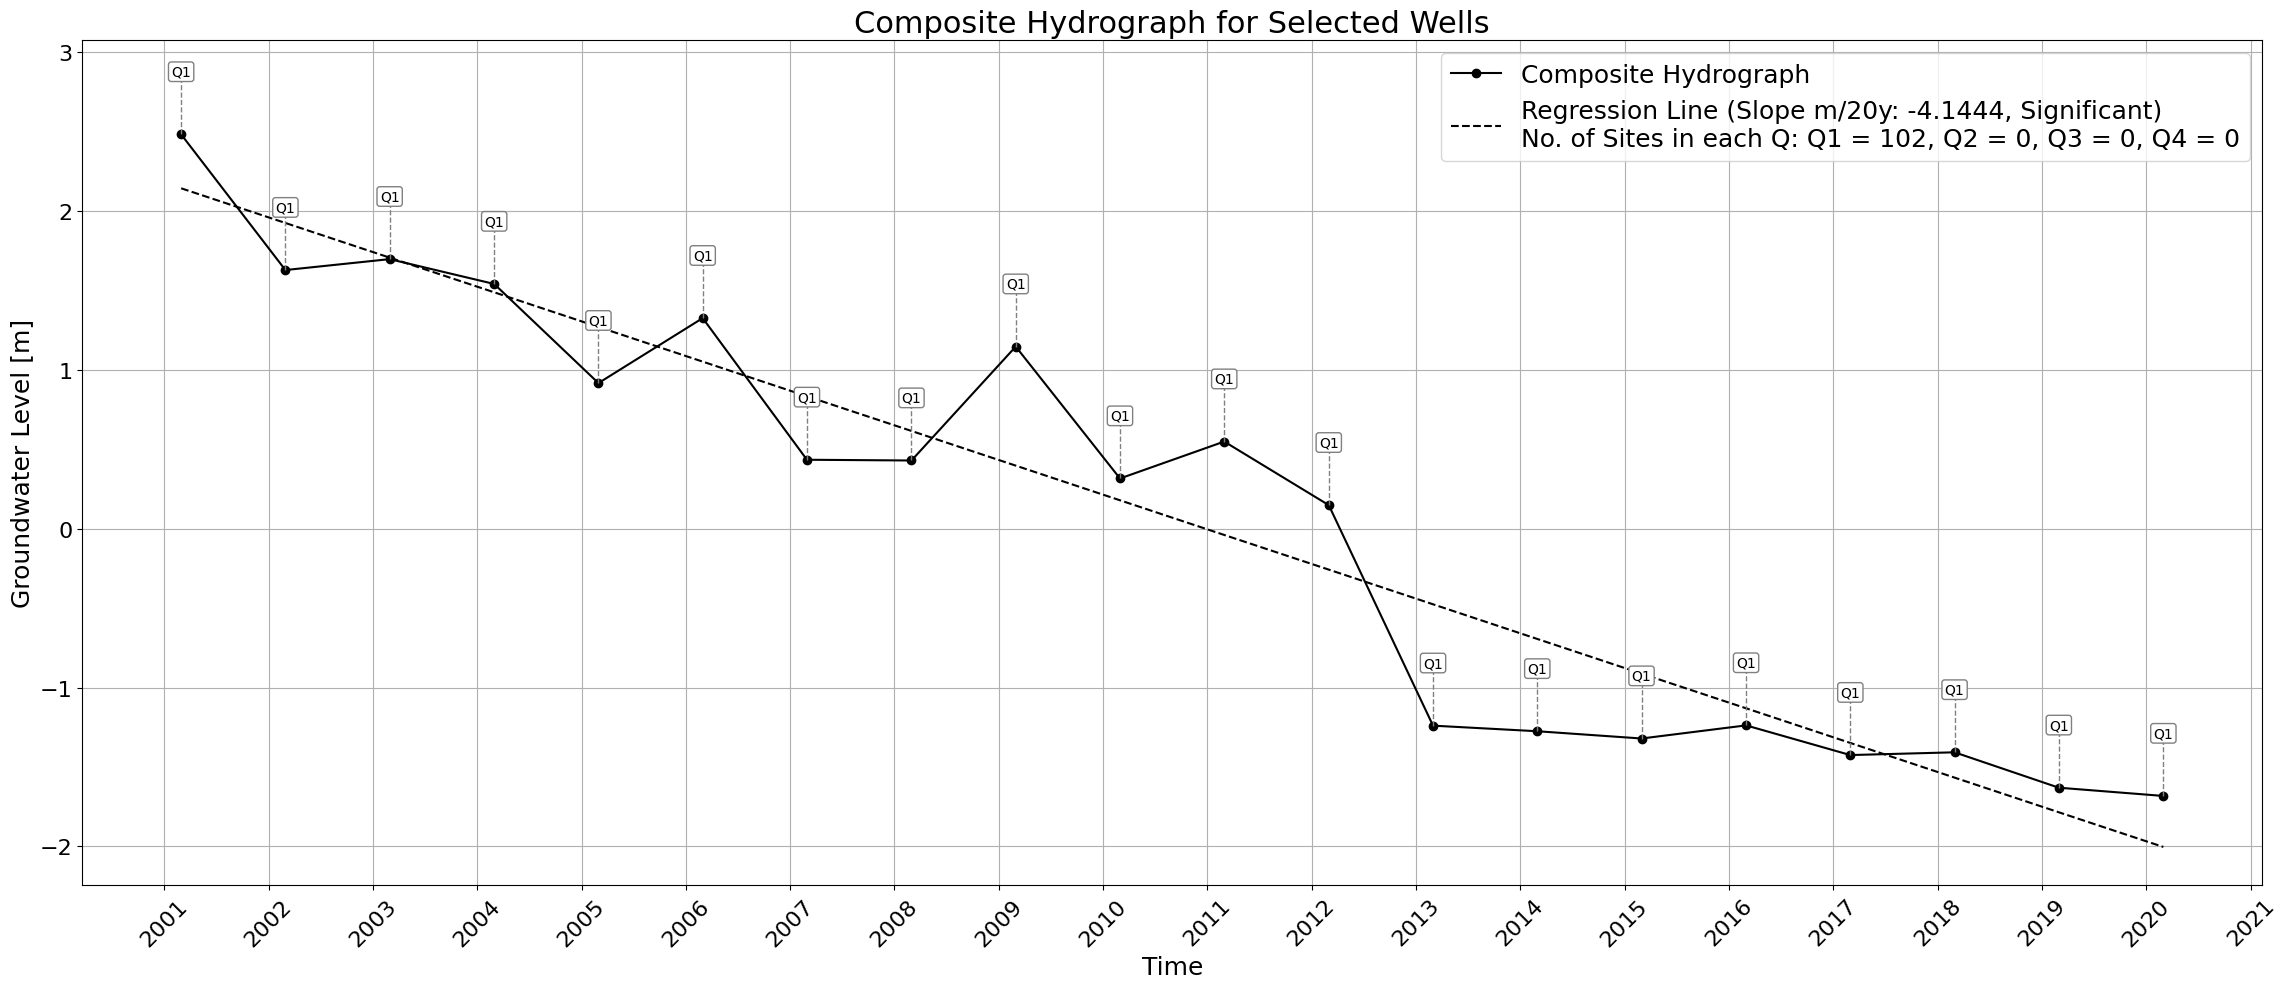

CPU times: total: 53.4 s
Wall time: 56 s


In [ ]:
%%time

import winsound
import datetime
import pandas as pd
import pymannkendall as mk
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
import os

file_path = 'Colorado_sites.csv'             # Replace with the actual path to your CSV file
date_end = '2020-12-31'                      # The date prior to which you want to conduct the analysis
num_of_years = 20                            # Number of years prior to which the analysis needs to be conducted aka the total timeframe
state_filter = True                          # Do you want to filter using a state (True/False)
name_state = 'Colorado'                      # If True then which state? 'Texas' 'Colorado' 'Oklahoma' 'Kansas' 'Nebraska' 'New Mexico' 'South Dakota'
resample_period = '3MS'                      # What is the resample period of your data? # D, B, M, 6M, Q, Y. 
data_filter = True                           # Do you want to drop sites if they have missing data more than a particular % ereshold? (True/False) 
threshold = 10                               # What is this threshold in percentage?

"""
Frequency strings for time intervals in pandas:
D: Calendar daily
B: Business daily
W: Weekly
M: Month end
6M: 6 Monthly
Q: Quarter end
A: Year end
H: Hourly
T/min: Minutely
S: Secondly
"""


"""

Output Folder Name =  Threshold%_Time Period_ if filtered by state _ if data filtered

"""

output_folder = f"{threshold}%_{resample_period}_{name_state if state_filter else 'NAState'}_{'Filtered' if data_filter else 'Unfiltered'}"
os.makedirs(output_folder, exist_ok=True)


"""

Time Frame, Resampling and Unit Selection

"""
# Load the CSV file
df = pd.read_csv(file_path)

# Convert the date column to datetime format with dayfirst=True
df['date'] = pd.to_datetime(df['date'])

# Define the time frame
end_date = pd.to_datetime(date_end)  # The prior to which you want to conduct the analysis
start_date = end_date - pd.DateOffset(years = num_of_years)  # Number of years prior to which the analysis needs to be conducted

# Select the rows within the specified time frame
selected_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Optional: Filter by the "state" column to select only rows with "Nebraska"
filter_state = state_filter  # Set this to False if you don't want to filter by state

if filter_state:
    state_name = name_state
    output_file_name = f'1_data_{state_name}.csv'
else:
    output_file_name = '1_data.csv'
    
    


# Separate the data into four dataframes based on the values' positions within each year
dataframes = []

for year in range(4):
    # Filter data for the specific position within each year
    filtered_data = selected_data[selected_data['date'].dt.month.isin([3 * year + 1, 3 * year + 2, 3 * year + 3])]
    # Create a new dataframe for the filtered data
    dataframes.append(filtered_data)

# Now dataframes[0] contains the first value for each year for each site, dataframes[1] contains the second value, and so on

#Access the dataframes
Q1 = dataframes[0]
Q2 = dataframes[1]
Q3 = dataframes[2]
Q4 = dataframes[3]


Q1_output_file_name = 'Q1.csv'
Q1_output_file_path = os.path.join(output_folder, Q1_output_file_name)
Q1.to_csv(Q1_output_file_path, index=False) 

Q2_output_file_name = 'Q2.csv'
Q2_output_file_path = os.path.join(output_folder, Q2_output_file_name)
Q2.to_csv(Q2_output_file_path, index=False)


Q3_output_file_name = 'Q3.csv'
Q3_output_file_path = os.path.join(output_folder, Q3_output_file_name)
Q3.to_csv(Q3_output_file_path, index=False)

Q4_output_file_name = 'Q4.csv'
Q4_output_file_path = os.path.join(output_folder, Q4_output_file_name)
Q4.to_csv(Q4_output_file_path, index=False)


# Input whether you want to apply the optional code or not
apply_filtering = data_filter  # Change this to True if you want to apply the optional code

if apply_filtering:
    

    # Calculate missing percentages and identify sites to drop
    missing_percentage = []
    sites_to_drop = []

    for quarter_df in dataframes:
        missing_percentage.append(
            quarter_df.groupby('site')['level'].apply(lambda x: x.isnull().mean() * 100)
        )

    for quarter_missing_percentage in missing_percentage:
        sites_to_drop.append(
            quarter_missing_percentage[quarter_missing_percentage > threshold].index.tolist()
        )

    # Create updated filtered dataframes
    updated_dataframes = []

    for i, quarter_df in enumerate(dataframes):
        updated_df = quarter_df[~quarter_df['site'].isin(sites_to_drop[i])]
        updated_dataframes.append(updated_df)

    # Save updated dataframes to CSV files
    for i, updated_df in enumerate(updated_dataframes):
        updated_output_file_name = f'Filtered_Q{i + 1}.csv'
        updated_output_file_path = os.path.join(output_folder, updated_output_file_name)
        updated_df.to_csv(updated_output_file_path, index=False)

    # Merge the four dataframes into one
    merged_dataframe = pd.concat(updated_dataframes, ignore_index=True)


    # Now, 'merged_dataframe' contains all the data from the four dataframes
    analysis_data = merged_dataframe.copy()

    # Sort the merged_dataframe by 'date' for each 'site'
    analysis_data.sort_values(by=['site', 'date'], inplace=True)
    analysis_data = analysis_data.dropna()
    analysis_data.set_index('date')

    
else:
    analysis_data = selected_data.copy().dropna()
    analysis_data.set_index('date')



    
    
"""

Post Aggregation Mann Kendall

"""

mk_results = [] # Initialize a list to store results
skipped_sites = []  # Initialize a list to store skipped sites

# Loop through each unique site in the analysis data
for site in analysis_data['site'].unique():
    site_data = analysis_data[analysis_data['site'] == site]
    for col in ['level']:
        # Skip sites with no variability
        if site_data[col].nunique() > 1:
            # Perform Mann-Kendall test using user-inputted alpha or default value
            mk_test = mk.original_test(site_data[col], alpha=0.05)
            mk_results.append((site, col, mk_test.trend, mk_test.h,
                               mk_test.p, mk_test.z, mk_test.Tau, mk_test.s, mk_test.var_s,
                               mk_test.slope, mk_test.intercept, mk_test.slope*80))
        else:
            skipped_sites.append(site)  # Add the site to the skipped_sites list

# Define columns for the Mann-Kendall results
mk_columns = ['site', 'data_type', 'trend', 'h', 'p', 'z', 'Tau', 's', 'var_s', 'slope', 'intercept', 'slope m/20y']

# Create a DataFrame from the Mann-Kendall results
mk_result_df = pd.DataFrame(mk_results, columns=mk_columns)

# Calculate the percentage of increasing and decreasing trends
trends = mk_result_df[mk_result_df['data_type'] == 'level']['trend']
num_increasing = sum(trends == "increasing")
num_decreasing = sum(trends == "decreasing")
num_no_trend = sum(trends == "no trend")
total_trends = len(trends)

percentage_increasing = (num_increasing / total_trends) * 100
percentage_decreasing = (num_decreasing / total_trends) * 100
percentage_no_trend = (num_no_trend / total_trends) * 100

# Create DataFrames for the three sheets
skipped_sites_df = pd.DataFrame({'Skipped Sites': skipped_sites})
trend_percentage_df = pd.DataFrame({
    'Number of Increasing Trends': num_increasing,
    'Number of Decreasing Trends': num_decreasing,
    'Number of No Trends': num_no_trend,
    'Percentage of Increasing Trends': percentage_increasing,
    'Percentage of Decreasing Trends': percentage_decreasing,
    'Percentage of No Trends': percentage_no_trend
}, index=[0])


# Save results to an Excel file with multiple sheets
excel_file_path = os.path.join(output_folder, 'Post_Agre_MK.xlsx')

with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    mk_result_df.to_excel(writer, sheet_name='Mann-Kendall Results', index=False)
    skipped_sites_df.to_excel(writer, sheet_name='Skipped Sites', index=False)
    trend_percentage_df.to_excel(writer, sheet_name='Trend Percentages', index=False)

print(f"Results saved to Excel file: {excel_file_path}")


"""

Post Aggregation Linear Regression with graphs

"""

# Perform linear regression for each site and level values

linear_regression_results = []
skipped_sites = []

# Loop through each unique site in the analysis data
for site in analysis_data['site'].unique():
    site_data = analysis_data[analysis_data['site'] == site]
    for col in ['level']:
        # Skip sites with no variability
        if site_data[col].nunique() > 1:
            x = np.arange(len(site_data))  # Assuming x represents time or index
            y = site_data[col]
            
            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            trend = "Increasing" if slope * 80 > 2 else "Decreasing" if slope * 80 < -2 else "No trend"  # slope in m per 20 years
            
            # Check if the p-value is less than 0.05 (95% confidence level)
            if p_value < 0.05:
                significance = "Significant" 
            else:
                significance = "Insignificant"
                
            linear_regression_results.append((site, col, slope, intercept, trend, slope * 80, p_value, significance))  # Add the slope m/20y and p-value
        else:
            skipped_sites.append(site)  # Add the site to the skipped_sites list

# Define columns for the linear regression results, including the new 'slope m/20y' and 'p-value' columns
linear_regression_columns = ['site', 'data_type', 'slope', 'intercept', 'trend', 'slope m/20y', 'p-value', 'significance']

# Create DataFrame for linear regression results
linear_regression_df = pd.DataFrame(linear_regression_results, columns=linear_regression_columns)

# Calculate the percentage of increasing and decreasing trends for linear regression
trends = linear_regression_df[linear_regression_df['data_type'] == 'level']['trend']
num_increasing = sum(trends == "Increasing")
num_decreasing = sum(trends == "Decreasing")
num_no_trend = sum(trends == "No trend")
total_trends = len(trends)

percentage_increasing = (num_increasing / total_trends) * 100
percentage_decreasing = (num_decreasing / total_trends) * 100
percentage_no_trend = (num_no_trend / total_trends) * 100

# Create DataFrames for the three sheets
skipped_sites_df = pd.DataFrame({'Skipped Sites': skipped_sites})
trend_percentage_df = pd.DataFrame({
    'Number of Increasing Trends': num_increasing,
    'Number of Decreasing Trends': num_decreasing,
    'Number of No Trends': num_no_trend,
    'Percentage of Increasing Trends': percentage_increasing,
    'Percentage of Decreasing Trends': percentage_decreasing,
    'Percentage of No Trends': percentage_no_trend
}, index=[0])

# Save results to an Excel file with multiple sheets
excel_file_path = os.path.join(output_folder, 'Post_Agri_LR.xlsx')

with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    linear_regression_df.to_excel(writer, sheet_name='Linear Regression Results', index=False)
    skipped_sites_df.to_excel(writer, sheet_name='Skipped Sites', index=False)
    trend_percentage_df.to_excel(writer, sheet_name='Trend Percentages', index=False)

print(f"Results saved to Excel file: {excel_file_path}")





# Create a folder to save graphs
graphs_folder = os.path.join(output_folder, 'graphs')
os.makedirs(graphs_folder, exist_ok=True)

# Define the offset value (adjust as needed)
label_offset = 1  # Adjust the offset as needed

# Loop through each unique site
for site in analysis_data['site'].unique():
    site_data = analysis_data[analysis_data['site'] == site]
    
    # Check if there's enough data for linear regression
    if len(site_data) < 2:
        print(f"Skipping site {site} due to insufficient data.")
        continue
    
    # Prepare data for linear regression
    x = mdates.date2num(site_data['date'])  # Convert datetime to numeric values
    y = site_data['level']
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    
    # Get the slope (trend) value from the linear_regression_df for the current site
    slope_info = linear_regression_df[(linear_regression_df['site'] == site) & (linear_regression_df['data_type'] == 'level')]
    
    if not slope_info.empty:
        slope_m_20y = slope_info['slope m/20y'].values[0]
    else:
        # Handle the case where there is no data for the current site
        print(f"No slope data found for site {site}. Skipping.")
        continue  # Skip this site and move on to the next one
    
    # Get the trend information from your linear_regression_results DataFrame
    trend_info = linear_regression_df[(linear_regression_df['site'] == site) & (linear_regression_df['data_type'] == 'level')]
    
    # Extract the trend and p-value
    trend = trend_info['trend'].values[0]
    p_value = trend_info['p-value'].values[0]
    significance = trend_info['significance'].values[0]
    # Create the plot
    fig, ax = plt.subplots(figsize=(23, 10))
    
    # Plot the time series data in black with a custom legend label including trend, slope, and p-value
    label = f'Hydrograph'
    plt.plot(site_data['date'], y, color='black', label=label, marker='o', markersize=4, linestyle='-')
    
    # Plot the linear regression line in black with a custom legend label including slope_m_20y
    label = f'Regression Line (Slope m/20y: {slope_m_20y:.2f}, {significance})'
    x_regression = mdates.num2date(x)  # Convert numeric values back to datetime
    y_regression = model.predict(x.reshape(-1, 1))
    plt.plot(x_regression, y_regression, color='black', linestyle='dashed', label=label)
    
    # Set axes labels and title
    ax.set_xlabel('Date', fontsize=18)  # Adjust the fontsize as needed
    ax.set_ylabel('Groundwater Level [m]', fontsize=18)  # Adjust the fontsize as needed
    ax.set_title(f'Composite Hydrograph for  {site}', fontsize=22)
    
    ax.grid()
    
    # Add legend with increased font size
    plt.legend(fontsize=18)
    
    # Increase the fontsize of the water level numbers on the y-axis
    plt.yticks(fontsize=16)  # Adjust the fontsize as needed
    
    # Set the x-axis locator to display every year
    ax.xaxis.set_major_locator(mdates.YearLocator())
    
    # Rotate and increase the fontsize of the x-axis labels
    plt.xticks(rotation=45, fontsize=16)  # Adjust the fontsize as needed
    
    # Add labels for each data point with customized month values and bbox
    for date_val, level_val in zip(site_data['date'], y):
        month = date_val.strftime('%b')  # Format to display only the month
        if month == 'Mar':
            label = 'Q1'
        elif month == 'Jun':
            label = 'Q2'
        elif month == 'Sep':
            label = 'Q3'
        elif month == 'Dec':
            label = 'Q4'
        else:
            label = month
        
        # Calculate the label position based on the data point position
        label_x = date_val
        label_y = level_val + label_offset
        
        bbox_props = dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white')
        plt.annotate(
            label,
            (label_x, label_y),
            xytext=(0, 0),
            textcoords='offset points',
            ha='center',
            va='bottom',
            fontsize=10,
            bbox=bbox_props
        )
        
        # Draw a line from the data point to the label
        plt.plot([date_val, label_x], [level_val, label_y], color='gray', linestyle='--', linewidth=1)
    
    # Save the plot as an image without displaying it
    plt.savefig(os.path.join(graphs_folder, f'Site_{site}.png'), bbox_inches='tight')
    
    # Close the plot
    plt.close()

print("Individual site graphs have been saved in the 'graphs' folder.")


"""
Pre Aggregation Processing All Q

"""


# Load and preprocess the data
aggregation_data = analysis_data.copy()

# Convert 'date' column to DateTime format
aggregation_data['date'] = pd.to_datetime(aggregation_data['date'])

# Set 'date' as the DataFrame index
aggregation_data.set_index('date', inplace=True)


# Calculate the site mean for each site in aggregation_data
site_means = aggregation_data.groupby('site')['level'].mean()

# Create a new column 'normalised_level' by subtracting the site mean from each level value
aggregation_data['normalised_level'] = aggregation_data.apply(lambda row: row['level'] - site_means[row['site']], axis=1)

# and calculate the mean of 'normalised_level' for each time step
average_normalised_level = aggregation_data['normalised_level'].resample(resample_period).mean()

# Optionally, you can reset the index to have 'date' as a regular column
average_normalised_level = average_normalised_level.reset_index()
average_normalised_level.set_index('date', inplace=True)


# Save the resampled data to a CSV file
average_normalised_level_output_path = os.path.join(output_folder, '3_aggregated_data.csv')
average_normalised_level.to_csv(average_normalised_level_output_path, index=True)
aggregated_data_df = average_normalised_level.copy().reset_index().dropna()



"""

Pre Aggregated Tests All Q

"""

# Assuming aggregated_data_df is your DataFrame containing the data
aggregated_data_df['date'] = pd.to_datetime(aggregated_data_df['date'], format="%d-%b-%y")
y_values = aggregated_data_df['normalised_level']
x_values = np.linspace(0, 1, len(aggregated_data_df['normalised_level']))

# Cleaning NaN
idx = np.isfinite(x_values) & np.isfinite(y_values)
slope, b = np.polyfit(x_values[idx], y_values[idx], 1)

linear_fit = x_values * slope + b

fig, ax = plt.subplots(figsize=(23, 10))  # Adjust the figure size (wider)

# Drop NaN values
aggregated_data_df_cleaned = aggregated_data_df.dropna()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_values[idx], y_values[idx])


# Determine whether the slope is significant
p_value_threshold = 0.05
slope_significant = p_value < p_value_threshold


number_sites = analysis_data['site'].nunique()

# Calculate the number of unique sites in each quarter
uq1_sites = (len([value for value in Q1['level'] if not pd.isna(value)]) / len(Q1['level'])) * 100
uq2_sites = (len([value for value in Q2['level'] if not pd.isna(value)]) / len(Q2['level'])) * 100
uq3_sites = (len([value for value in Q3['level'] if not pd.isna(value)]) / len(Q3['level'])) * 100
uq4_sites = (len([value for value in Q4['level'] if not pd.isna(value)]) / len(Q4['level'])) * 100

if data_filter:
    # Calculate the number of unique sites in each quarter
    q1_sites = updated_dataframes[0]['site'].nunique()
    q2_sites = updated_dataframes[1]['site'].nunique()
    q3_sites = updated_dataframes[2]['site'].nunique()
    q4_sites = updated_dataframes[3]['site'].nunique()
    legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites in each Q: Q1 = {q1_sites}, Q2 = {q2_sites}, Q3 = {q3_sites}, Q4 = {q4_sites}'

else:
    legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites: {number_sites}: Q1% = {uq1_sites:.1f}, Q2% = {uq2_sites:.1f}, Q3% = {uq3_sites:.1f}, Q4% = {uq4_sites :.1f}'

    
# Plot the composite hydrograph (solid)
plt.plot(aggregated_data_df['date'], aggregated_data_df['normalised_level'], color='black', label='Composite Hydrograph', marker='o', markersize=6, linestyle='-')

# Plot the linear regression line with the updated legend label
plt.plot(aggregated_data_df['date'], linear_fit, color='#000000', linestyle='dashed', label=legend_label)

# Set axes labels and title with increased font size
ax.set_xlabel('Time', fontsize=18)  # Adjust the fontsize as needed
ax.set_ylabel('Groundwater Level [m]', fontsize=18)  # Adjust the fontsize as needed
ax.set_title('Composite Hydrograph for Selected Wells', fontsize=22)

ax.grid()

# Add legend with increased font size
plt.legend(fontsize=18)

# Increase the fontsize of the water level numbers on the y-axis
plt.yticks(fontsize=16)  # Adjust the fontsize as needed

# Set the x-axis locator to display every year
ax.xaxis.set_major_locator(mdates.YearLocator())

# Rotate and increase the fontsize of the x-axis labels
plt.xticks(rotation=45, fontsize=16)  # Adjust the fontsize as needed

# Define label offset
label_offset = 0.35

# Add data point labels with lines
for i, date in enumerate(aggregated_data_df['date']):
    month = date.strftime('%b')  # Format to display only the month
    if month == 'Mar':
        label = 'Q1'
    elif month == 'Jun':
        label = 'Q2'
    elif month == 'Sep':
        label = 'Q3'
    elif month == 'Dec':
        label = 'Q4'
    else:
        label = month
    label_x = date
    label_y = aggregated_data_df['normalised_level'].iloc[i] + label_offset
    plt.annotate(label, (label_x, label_y), xytext=(0, 0), textcoords='offset points', ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white'))
    
    # Draw a line from the data point to the label
    plt.plot([date, label_x], [aggregated_data_df['normalised_level'].iloc[i], label_y], color='gray', linestyle='--', linewidth=1)

# Adjust layout to best fit
plt.tight_layout()

# Save the plot as an image
plot_filename = os.path.join(output_folder, 'Pre_aggre_All_Q.png')
plt.savefig(plot_filename, bbox_inches='tight')

# Show the plot
plt.show()


# Perform Mann-Kendall test
mk_result = mk.original_test(aggregated_data_df['normalised_level'])

# Define columns for the Mann-Kendall results
mk_columns = ['trend', 'h', 'p', 'z', 'Tau', 's', 'var_s', 'sens_slope', 'sens_intercept', 'slope_lr', 'slope m/20y', 'p-value LR', 'Trend Significance']

# Determine trend significance based on LR p-value
trend_significance = "Significant" if p_value < 0.05 else "Not Significant"

# Create a DataFrame for Mann-Kendall results
mk_result_df = pd.DataFrame({
    'trend': [mk_result.trend],
    'h': [mk_result.h],
    'p': [mk_result.p],
    'z': [mk_result.z],
    'Tau': [mk_result.Tau],
    's': [mk_result.s],
    'var_s': [mk_result.var_s],
    'sens_slope': [mk_result.slope],
    'sens_intercept': [mk_result.intercept],
    'slope LR m/20y': [slope],
    'slope MK m/20y': [mk_result.slope * 80],
    'p-value LR': [p_value],  # Adding the p-value from linear regression
    'Trend Significance': [trend_significance],  # Adding the trend significance
})

# Save the DataFrames to separate Excel files
mk_result_excel_path = os.path.join(output_folder, 'Pre_Agre_results.xlsx')
mk_result_df.to_excel(mk_result_excel_path, index=False)




In [ ]:
"""
Pre-Aggregation Processing Q1
"""
if data_filter:
    aggregation_data_Q1 = updated_dataframes[0]
else:
    aggregation_data_Q1 = dataframes[0]
    
aggregation_data_Q1.loc[:,'date'] = pd.to_datetime(aggregation_data_Q1['date'])
aggregation_data_Q1.set_index('date', inplace=True)
site_means = aggregation_data_Q1.groupby('site')['level'].mean()
aggregation_data_Q1['normalised_level'] = aggregation_data_Q1['level'] - aggregation_data_Q1.groupby('site')['level'].transform('mean')
# aggregation_data_Q1.loc[:, 'normalised_level'] = aggregation_data_Q1['level'] - aggregation_data_Q1.groupby('site')['level'].transform('mean')
average_normalised_level_Q1 = aggregation_data_Q1['normalised_level'].resample(resample_period).mean()
average_normalised_level_Q1 = average_normalised_level_Q1.reset_index()
average_normalised_level_Q1.set_index('date', inplace=True)
average_normalised_level_Q1_output_path = os.path.join(output_folder, '3_Aggregated_data_Q1.csv')
average_normalised_level_Q1.to_csv(average_normalised_level_Q1_output_path, index=True)
aggregated_data_df_Q1 = average_normalised_level_Q1.copy().reset_index().dropna()




C:\Users\ferns\AppData\Local\Temp\ipykernel_17076\1008104847.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregation_data_Q1['normalised_level'] = aggregation_data_Q1['level'] - aggregation_data_Q1.groupby('site')['level'].transform('mean')


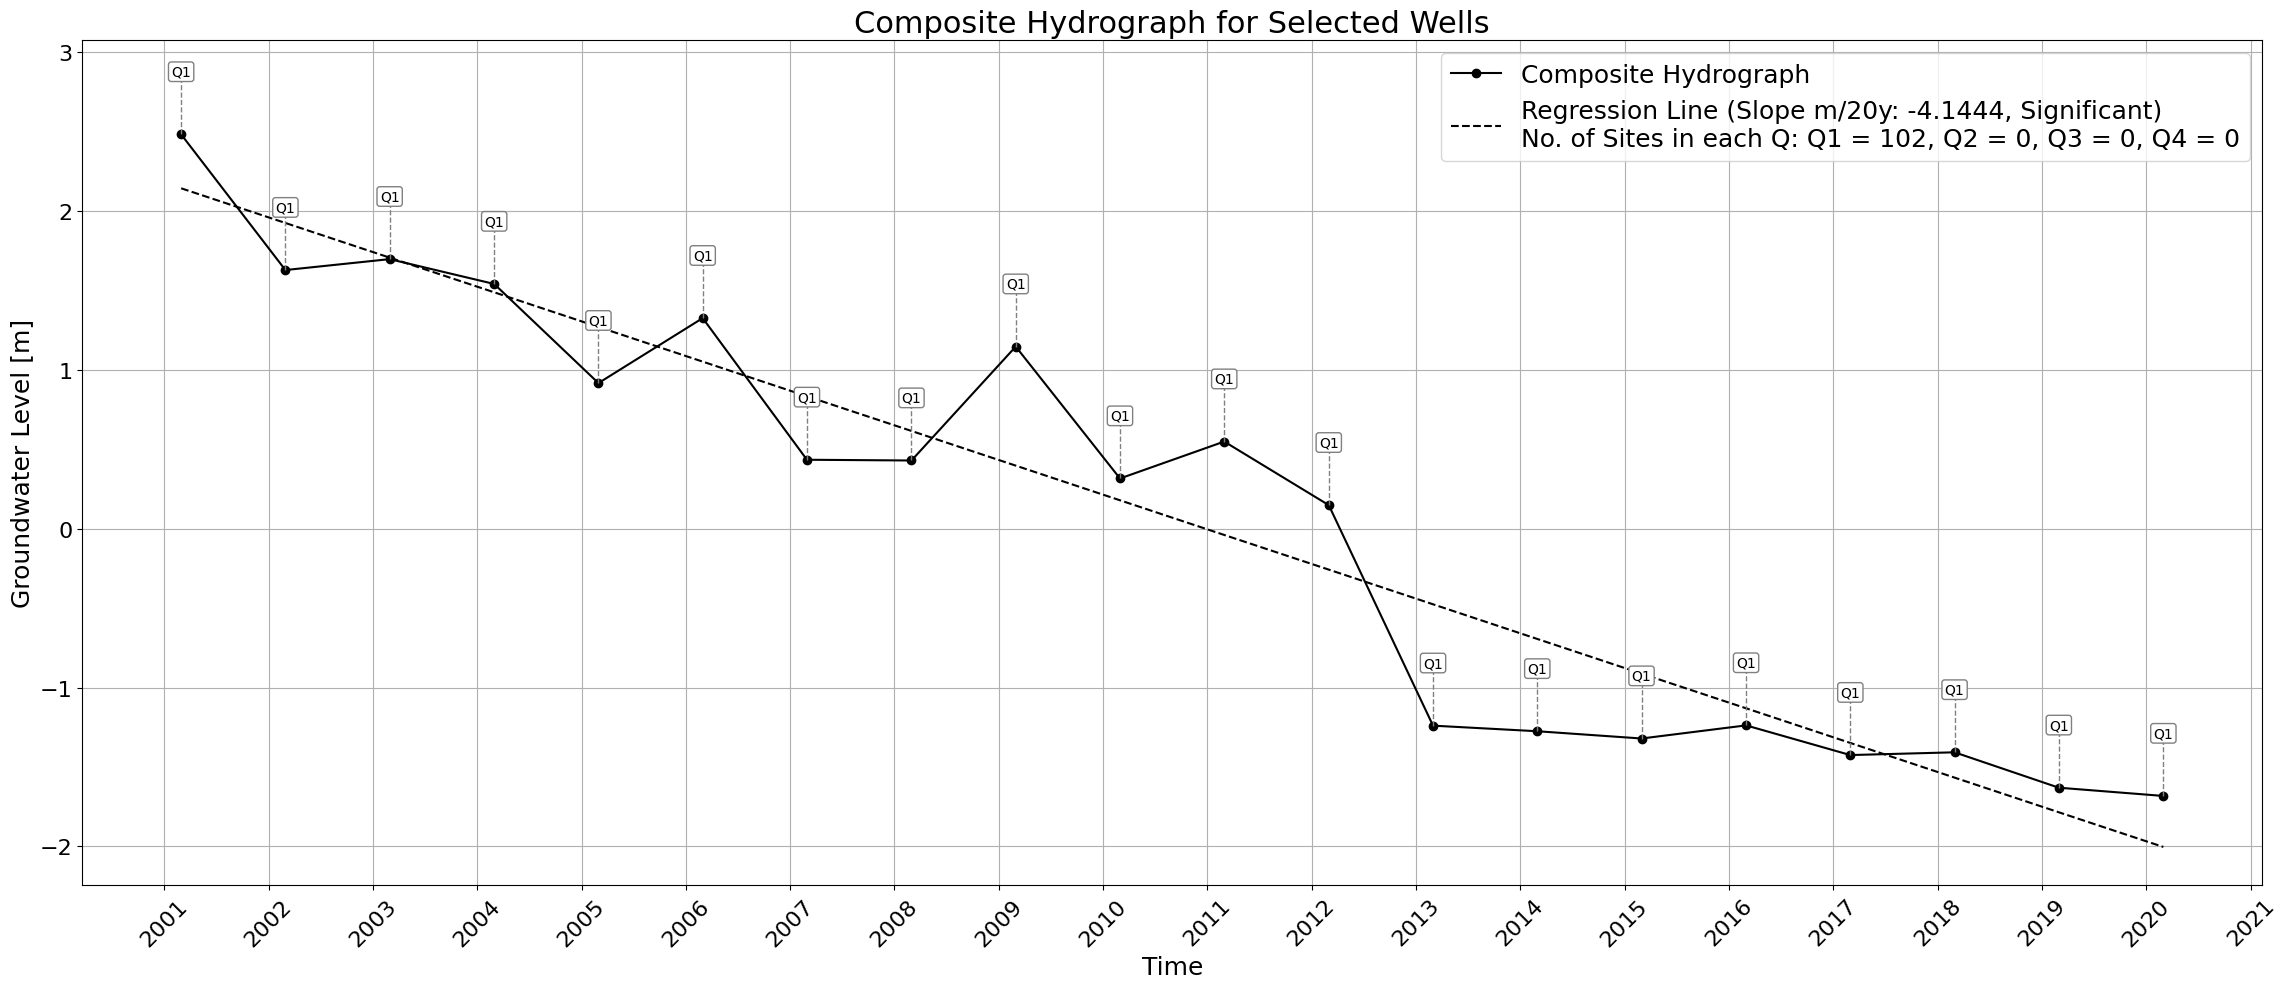

In [ ]:
"""

Pre Aggregated Tests Q1

"""

# Assuming aggregated_data_df is your DataFrame containing the data
aggregated_data_df_Q1['date'] = pd.to_datetime(aggregated_data_df_Q1['date'], format="%d-%b-%y")
y_values = aggregated_data_df_Q1['normalised_level']
x_values = np.linspace(0, 1, len(aggregated_data_df_Q1['normalised_level']))

# Cleaning NaN
idx = np.isfinite(x_values) & np.isfinite(y_values)

# Check if the DataFrame is empty
if not aggregated_data_df_Q1.empty and np.any(idx):

    slope, b = np.polyfit(x_values[idx], y_values[idx], 1)

    linear_fit = x_values * slope + b

    fig, ax = plt.subplots(figsize=(23, 10))  # Adjust the figure size (wider)

    # Drop NaN values
    aggregated_data_df_cleaned_Q1 = aggregated_data_df_Q1.dropna()

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values[idx], y_values[idx])


    # Determine whether the slope is significant
    p_value_threshold = 0.05
    slope_significant = p_value < p_value_threshold


    number_sites = analysis_data['site'].nunique()

    # Calculate the number of unique sites in each quarter
    uq1_sites = (len([value for value in Q1['level'] if not pd.isna(value)]) / len(Q1['level'])) * 100
    uq2_sites = (len([value for value in Q2['level'] if not pd.isna(value)]) / len(Q2['level'])) * 100
    uq3_sites = (len([value for value in Q3['level'] if not pd.isna(value)]) / len(Q3['level'])) * 100
    uq4_sites = (len([value for value in Q4['level'] if not pd.isna(value)]) / len(Q4['level'])) * 100

    if data_filter:
        # Calculate the number of unique sites in each quarter
        q1_sites = updated_dataframes[0]['site'].nunique()
        q2_sites = updated_dataframes[1]['site'].nunique()
        q3_sites = updated_dataframes[2]['site'].nunique()
        q4_sites = updated_dataframes[3]['site'].nunique()
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites in each Q: Q1 = {q1_sites}, Q2 = {q2_sites}, Q3 = {q3_sites}, Q4 = {q4_sites}'

    else:
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites: {number_sites}: Q1% = {uq1_sites:.1f}, Q2% = {uq2_sites:.1f}, Q3% = {uq3_sites:.1f}, Q4% = {uq4_sites :.1f}'


    # Plot the composite hydrograph (solid)
    plt.plot(aggregated_data_df_Q1['date'], aggregated_data_df_Q1['normalised_level'], color='black', label='Composite Hydrograph', marker='o', markersize=6, linestyle='-')

    # Plot the linear regression line with the updated legend label
    plt.plot(aggregated_data_df_Q1['date'], linear_fit, color='#000000', linestyle='dashed', label=legend_label)

    # Set axes labels and title with increased font size
    ax.set_xlabel('Time', fontsize=18)  # Adjust the fontsize as needed
    ax.set_ylabel('Groundwater Level [m]', fontsize=18)  # Adjust the fontsize as needed
    ax.set_title('Composite Hydrograph for Selected Wells', fontsize=22)

    ax.grid()

    # Add legend with increased font size
    plt.legend(fontsize=18)

    # Increase the fontsize of the water level numbers on the y-axis
    plt.yticks(fontsize=16)  # Adjust the fontsize as needed

    # Set the x-axis locator to display every year
    ax.xaxis.set_major_locator(mdates.YearLocator())

    # Rotate and increase the fontsize of the x-axis labels
    plt.xticks(rotation=45, fontsize=16)  # Adjust the fontsize as needed

    # Define label offset
    label_offset = 0.35

    # Add data point labels with lines
    for i, date in enumerate(aggregated_data_df_Q1['date']):
        month = date.strftime('%b')  # Format to display only the month
        if month == 'Mar':
            label = 'Q1'
        elif month == 'Jun':
            label = 'Q2'
        elif month == 'Sep':
            label = 'Q3'
        elif month == 'Dec':
            label = 'Q4'
        else:
            label = month
        label_x = date
        label_y = aggregated_data_df_Q1['normalised_level'].iloc[i] + label_offset
        plt.annotate(label, (label_x, label_y), xytext=(0, 0), textcoords='offset points', ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white'))

        # Draw a line from the data point to the label
        plt.plot([date, label_x], [aggregated_data_df_Q1['normalised_level'].iloc[i], label_y], color='gray', linestyle='--', linewidth=1)

    # Adjust layout to best fit
    plt.tight_layout()

    # Save the plot as an image
    plot_filename = os.path.join(output_folder, 'Pre_aggre_Q1.png')
    plt.savefig(plot_filename, bbox_inches='tight')

    # Show the plot
    plt.show()


    # Perform Mann-Kendall test
    mk_result = mk.original_test(aggregated_data_df_Q1['normalised_level'])

    # Define columns for the Mann-Kendall results
    mk_columns = ['trend', 'h', 'p', 'z', 'Tau', 's', 'var_s', 'sens_slope', 'sens_intercept', 'slope_lr', 'slope m/20y', 'p-value LR', 'Trend Significance']

    # Determine trend significance based on LR p-value
    trend_significance = "Significant" if p_value < 0.05 else "Not Significant"

    # Create a DataFrame for Mann-Kendall results
    mk_result_df = pd.DataFrame({
        'trend': [mk_result.trend],
        'h': [mk_result.h],
        'p': [mk_result.p],
        'z': [mk_result.z],
        'Tau': [mk_result.Tau],
        's': [mk_result.s],
        'var_s': [mk_result.var_s],
        'sens_slope': [mk_result.slope],
        'sens_intercept': [mk_result.intercept],
        'slope LR m/20y': [slope],
        'slope MK m/20y': [mk_result.slope * 80],
        'p-value LR': [p_value],  # Adding the p-value from linear regression
        'Trend Significance': [trend_significance],  # Adding the trend significance
    })

    # Save the DataFrames to separate Excel files
    mk_result_excel_path = os.path.join(output_folder, 'Pre_Agre_results_Q1.xlsx')
    mk_result_df.to_excel(mk_result_excel_path, index=False)

else:
    print("DataFrame is empty or contains no valid data for linear regression.")







In [ ]:
"""
Pre-Aggregation Processing Q2
"""

if data_filter:
    aggregation_data_Q2 = updated_dataframes[1]
else:
    aggregation_data_Q2 = dataframes[1]

aggregation_data_Q2.loc[:,'date'] = pd.to_datetime(aggregation_data_Q2['date'])
aggregation_data_Q2.set_index('date', inplace=True)
site_means = aggregation_data_Q2.groupby('site')['level'].mean()
aggregation_data_Q2['normalised_level'] = aggregation_data_Q2['level'] - aggregation_data_Q2.groupby('site')['level'].transform('mean')
average_normalised_level_Q2 = aggregation_data_Q2['normalised_level'].resample(resample_period).mean()
average_normalised_level_Q2 = average_normalised_level_Q2.reset_index()
average_normalised_level_Q2.set_index('date', inplace=True)
average_normalised_level_Q2_output_path = os.path.join(output_folder, '3_Aggregated_data_Q2.csv')
average_normalised_level_Q2.to_csv(average_normalised_level_Q2_output_path, index=True)
aggregated_data_df_Q2 = average_normalised_level_Q2.copy().reset_index().dropna()



In [ ]:
"""
Pre Aggregated Tests Q2
"""

# Assuming aggregated_data_df is your DataFrame containing the data
aggregated_data_df_Q2['date'] = pd.to_datetime(aggregated_data_df_Q2['date'], format="%d-%b-%y")
y_values = aggregated_data_df_Q2['normalised_level']
x_values = np.linspace(0, 1, len(aggregated_data_df_Q2['normalised_level']))

# Cleaning NaN
idx = np.isfinite(x_values) & np.isfinite(y_values)

if not aggregated_data_df_Q2.empty and np.any(idx):
    slope, b = np.polyfit(x_values[idx], y_values[idx], 1)

    linear_fit = x_values * slope + b

    fig, ax = plt.subplots(figsize=(23, 10))  # Adjust the figure size (wider)

    # Drop NaN values
    aggregated_data_df_Q2_cleaned = aggregated_data_df_Q2.dropna()

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values[idx], y_values[idx])


    # Determine whether the slope is significant
    p_value_threshold = 0.05
    slope_significant = p_value < p_value_threshold


    number_sites = analysis_data['site'].nunique()

    # Calculate the number of unique sites in each quarter
    uq1_sites = (len([value for value in Q1['level'] if not pd.isna(value)]) / len(Q1['level'])) * 100
    uq2_sites = (len([value for value in Q2['level'] if not pd.isna(value)]) / len(Q2['level'])) * 100
    uq3_sites = (len([value for value in Q3['level'] if not pd.isna(value)]) / len(Q3['level'])) * 100
    uq4_sites = (len([value for value in Q4['level'] if not pd.isna(value)]) / len(Q4['level'])) * 100

    if data_filter:
        # Calculate the number of unique sites in each quarter
        q1_sites = updated_dataframes[0]['site'].nunique()
        q2_sites = updated_dataframes[1]['site'].nunique()
        q3_sites = updated_dataframes[2]['site'].nunique()
        q4_sites = updated_dataframes[3]['site'].nunique()
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites in each Q: Q1 = {q1_sites}, Q2 = {q2_sites}, Q3 = {q3_sites}, Q4 = {q4_sites}'

    else:
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites: {number_sites}: Q1% = {uq1_sites:.1f}, Q2% = {uq2_sites:.1f}, Q3% = {uq3_sites:.1f}, Q4% = {uq4_sites :.1f}'


    # Plot the composite hydrograph (solid)
    plt.plot(aggregated_data_df_Q2['date'], aggregated_data_df_Q2['normalised_level'], color='black', label='Composite Hydrograph', marker='o', markersize=6, linestyle='-')

    # Plot the linear regression line with the updated legend label
    plt.plot(aggregated_data_df_Q2['date'], linear_fit, color='#000000', linestyle='dashed', label=legend_label)

    # Set axes labels and title with increased font size
    ax.set_xlabel('Time', fontsize=18)  # Adjust the fontsize as needed
    ax.set_ylabel('Groundwater Level [m]', fontsize=18)  # Adjust the fontsize as needed
    ax.set_title('Composite Hydrograph for Selected Wells', fontsize=22)

    ax.grid()

    # Add legend with increased font size
    plt.legend(fontsize=18)

    # Increase the fontsize of the water level numbers on the y-axis
    plt.yticks(fontsize=16)  # Adjust the fontsize as needed

    # Set the x-axis locator to display every year
    ax.xaxis.set_major_locator(mdates.YearLocator())

    # Rotate and increase the fontsize of the x-axis labels
    plt.xticks(rotation=45, fontsize=16)  # Adjust the fontsize as needed

    # Define label offset
    label_offset = 0.35

    # Add data point labels with lines
    for i, date in enumerate(aggregated_data_df_Q2['date']):
        month = date.strftime('%b')  # Format to display only the month
        if month == 'Mar':
            label = 'Q1'
        elif month == 'Jun':
            label = 'Q2'
        elif month == 'Sep':
            label = 'Q3'
        elif month == 'Dec':
            label = 'Q4'
        else:
            label = month
        label_x = date
        label_y = aggregated_data_df_Q2['normalised_level'].iloc[i] + label_offset
        plt.annotate(label, (label_x, label_y), xytext=(0, 0), textcoords='offset points', ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white'))

        # Draw a line from the data point to the label
        plt.plot([date, label_x], [aggregated_data_df_Q2['normalised_level'].iloc[i], label_y], color='gray', linestyle='--', linewidth=1)

    # Adjust layout to best fit
    plt.tight_layout()

    # Save the plot as an image
    plot_filename = os.path.join(output_folder, 'Pre_aggre_Q2.png')
    plt.savefig(plot_filename, bbox_inches='tight')

    # Show the plot
    plt.show()


    # Perform Mann-Kendall test
    mk_result = mk.original_test(aggregated_data_df_Q2['normalised_level'])

    # Define columns for the Mann-Kendall results
    mk_columns = ['trend', 'h', 'p', 'z', 'Tau', 's', 'var_s', 'sens_slope', 'sens_intercept', 'slope_lr', 'slope m/20y', 'p-value LR', 'Trend Significance']

    # Determine trend significance based on LR p-value
    trend_significance = "Significant" if p_value < 0.05 else "Not Significant"

    # Create a DataFrame for Mann-Kendall results
    mk_result_df = pd.DataFrame({
        'trend': [mk_result.trend],
        'h': [mk_result.h],
        'p': [mk_result.p],
        'z': [mk_result.z],
        'Tau': [mk_result.Tau],
        's': [mk_result.s],
        'var_s': [mk_result.var_s],
        'sens_slope': [mk_result.slope],
        'sens_intercept': [mk_result.intercept],
        'slope LR m/20y': [slope],
        'slope MK m/20y': [mk_result.slope * 80],
        'p-value LR': [p_value],  # Adding the p-value from linear regression
        'Trend Significance': [trend_significance],  # Adding the trend significance
    })

    # Save the DataFrames to separate Excel files
    mk_result_excel_path = os.path.join(output_folder, 'Pre_Agre_results_Q2.xlsx')
    mk_result_df.to_excel(mk_result_excel_path, index=False)
else:
    print("DataFrame is empty or contains no valid data for linear regression.")





DataFrame is empty or contains no valid data for linear regression.


In [ ]:
"""
Pre-Aggregation Processing Q3
"""

if data_filter:
    aggregation_data_Q3 = updated_dataframes[2]
else:
    aggregation_data_Q3 = dataframes[2]
    
aggregation_data_Q3.loc[:,'date'] = pd.to_datetime(aggregation_data_Q3['date'])
aggregation_data_Q3.set_index('date', inplace=True)
site_means = aggregation_data_Q3.groupby('site')['level'].mean()
aggregation_data_Q3['normalised_level'] = aggregation_data_Q3['level'] - aggregation_data_Q3.groupby('site')['level'].transform('mean')
average_normalised_level_Q3 = aggregation_data_Q3['normalised_level'].resample(resample_period).mean()
average_normalised_level_Q3 = average_normalised_level_Q3.reset_index()
average_normalised_level_Q3.set_index('date', inplace=True)
average_normalised_level_Q3_output_path = os.path.join(output_folder, '3_Aggregated_data_Q3.csv')
average_normalised_level_Q3.to_csv(average_normalised_level_Q3_output_path, index=True)
aggregated_data_df_Q3 = average_normalised_level_Q3.copy().reset_index().dropna()



"""
Pre Aggregated Tests Q3
"""
# Assuming aggregated_data_df is your DataFrame containing the data
aggregated_data_df_Q3['date'] = pd.to_datetime(aggregated_data_df_Q3['date'], format="%d-%b-%y")
y_values = aggregated_data_df_Q3['normalised_level']
x_values = np.linspace(0, 1, len(aggregated_data_df_Q3['normalised_level']))

# Cleaning NaN
idx = np.isfinite(x_values) & np.isfinite(y_values)

# Check if the DataFrame is empty
if not aggregated_data_df_Q3.empty and np.any(idx):
    # Perform linear regression and plotting here

    slope, b = np.polyfit(x_values[idx], y_values[idx], 1)

    linear_fit = x_values * slope + b

    fig, ax = plt.subplots(figsize=(23, 10))  # Adjust the figure size (wider)

    # Drop NaN values
    aggregated_data_df_Q3_cleaned = aggregated_data_df_Q3.dropna()

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values[idx], y_values[idx])


    # Determine whether the slope is significant
    p_value_threshold = 0.05
    slope_significant = p_value < p_value_threshold


    number_sites = analysis_data['site'].nunique()

    # Calculate the number of unique sites in each quarter
    uq1_sites = (len([value for value in Q1['level'] if not pd.isna(value)]) / len(Q1['level'])) * 100
    uq2_sites = (len([value for value in Q2['level'] if not pd.isna(value)]) / len(Q2['level'])) * 100
    uq3_sites = (len([value for value in Q3['level'] if not pd.isna(value)]) / len(Q3['level'])) * 100
    uq4_sites = (len([value for value in Q4['level'] if not pd.isna(value)]) / len(Q4['level'])) * 100

    if data_filter:
        # Calculate the number of unique sites in each quarter
        q1_sites = updated_dataframes[0]['site'].nunique()
        q2_sites = updated_dataframes[1]['site'].nunique()
        q3_sites = updated_dataframes[2]['site'].nunique()
        q4_sites = updated_dataframes[3]['site'].nunique()
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites in each Q: Q1 = {q1_sites}, Q2 = {q2_sites}, Q3 = {q3_sites}, Q4 = {q4_sites}'

    else:
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites: {number_sites}: Q1% = {uq1_sites:.1f}, Q2% = {uq2_sites:.1f}, Q3% = {uq3_sites:.1f}, Q4% = {uq4_sites :.1f}'


    # Plot the composite hydrograph (solid)
    plt.plot(aggregated_data_df_Q3['date'], aggregated_data_df_Q3['normalised_level'], color='black', label='Composite Hydrograph', marker='o', markersize=6, linestyle='-')

    # Plot the linear regression line with the updated legend label
    plt.plot(aggregated_data_df_Q3['date'], linear_fit, color='#000000', linestyle='dashed', label=legend_label)

    # Set axes labels and title with increased font size
    ax.set_xlabel('Time', fontsize=18)  # Adjust the fontsize as needed
    ax.set_ylabel('Groundwater Level [m]', fontsize=18)  # Adjust the fontsize as needed
    ax.set_title('Composite Hydrograph for Selected Wells', fontsize=22)

    ax.grid()

    # Add legend with increased font size
    plt.legend(fontsize=18)

    # Increase the fontsize of the water level numbers on the y-axis
    plt.yticks(fontsize=16)  # Adjust the fontsize as needed

    # Set the x-axis locator to display every year
    ax.xaxis.set_major_locator(mdates.YearLocator())

    # Rotate and increase the fontsize of the x-axis labels
    plt.xticks(rotation=45, fontsize=16)  # Adjust the fontsize as needed

    # Define label offset
    label_offset = 0.35

    # Add data point labels with lines
    for i, date in enumerate(aggregated_data_df_Q3['date']):
        month = date.strftime('%b')  # Format to display only the month
        if month == 'Mar':
            label = 'Q1'
        elif month == 'Jun':
            label = 'Q2'
        elif month == 'Sep':
            label = 'Q3'
        elif month == 'Dec':
            label = 'Q4'
        else:
            label = month
        label_x = date
        label_y = aggregated_data_df_Q3['normalised_level'].iloc[i] + label_offset
        plt.annotate(label, (label_x, label_y), xytext=(0, 0), textcoords='offset points', ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white'))

        # Draw a line from the data point to the label
        plt.plot([date, label_x], [aggregated_data_df_Q3['normalised_level'].iloc[i], label_y], color='gray', linestyle='--', linewidth=1)

    # Adjust layout to best fit
    plt.tight_layout()

    # Save the plot as an image
    plot_filename = os.path.join(output_folder, 'Pre_aggre_Q3.png')
    plt.savefig(plot_filename, bbox_inches='tight')

    # Show the plot
    plt.show()


    # Perform Mann-Kendall test
    mk_result = mk.original_test(aggregated_data_df_Q3['normalised_level'])

    # Define columns for the Mann-Kendall results
    mk_columns = ['trend', 'h', 'p', 'z', 'Tau', 's', 'var_s', 'sens_slope', 'sens_intercept', 'slope_lr', 'slope m/20y', 'p-value LR', 'Trend Significance']

    # Determine trend significance based on LR p-value
    trend_significance = "Significant" if p_value < 0.05 else "Not Significant"

    # Create a DataFrame for Mann-Kendall results
    mk_result_df = pd.DataFrame({
        'trend': [mk_result.trend],
        'h': [mk_result.h],
        'p': [mk_result.p],
        'z': [mk_result.z],
        'Tau': [mk_result.Tau],
        's': [mk_result.s],
        'var_s': [mk_result.var_s],
        'sens_slope': [mk_result.slope],
        'sens_intercept': [mk_result.intercept],
        'slope LR m/20y': [slope],
        'slope MK m/20y': [mk_result.slope * 80],
        'p-value LR': [p_value],  # Adding the p-value from linear regression
        'Trend Significance': [trend_significance],  # Adding the trend significance
    })

    # Save the DataFrames to separate Excel files
    mk_result_excel_path = os.path.join(output_folder, 'Pre_Agre_results_Q3.xlsx')
    mk_result_df.to_excel(mk_result_excel_path, index=False)
else:
    print("DataFrame is empty or contains no valid data for linear regression.")





DataFrame is empty or contains no valid data for linear regression.


In [ ]:
"""
Pre-Aggregation Processing Q4
"""


if data_filter:
    aggregation_data_Q4 = updated_dataframes[3]
else:
    aggregation_data_Q4 = dataframes[3]
    
aggregation_data_Q4.loc[:,'date'] = pd.to_datetime(aggregation_data_Q4['date'])
aggregation_data_Q4.set_index('date', inplace=True)
site_means = aggregation_data_Q4.groupby('site')['level'].mean()
aggregation_data_Q4['normalised_level'] = aggregation_data_Q4['level'] - aggregation_data_Q4.groupby('site')['level'].transform('mean')
average_normalised_level_Q4 = aggregation_data_Q4['normalised_level'].resample(resample_period).mean()
average_normalised_level_Q4 = average_normalised_level_Q4.reset_index()
average_normalised_level_Q4.set_index('date', inplace=True)
average_normalised_level_Q4_output_path = os.path.join(output_folder, '3_Aggregated_data_Q4.csv')
average_normalised_level_Q4.to_csv(average_normalised_level_Q4_output_path, index=True)
aggregated_data_df_Q4 = average_normalised_level_Q4.copy().reset_index().dropna()  


"""
Pre Aggregated Tests Q4
"""

# Assuming aggregated_data_df is your DataFrame containing the data
aggregated_data_df_Q4['date'] = pd.to_datetime(aggregated_data_df_Q4['date'], format="%d-%b-%y")
y_values = aggregated_data_df_Q4['normalised_level']
x_values = np.linspace(0, 1, len(aggregated_data_df_Q4['normalised_level']))

# Cleaning NaN
idx = np.isfinite(x_values) & np.isfinite(y_values)

# Check if the DataFrame is empty
if not aggregated_data_df_Q4.empty and np.any(idx):
    # Perform linear regression and plotting here


    slope, b = np.polyfit(x_values[idx], y_values[idx], 1)

    linear_fit = x_values * slope + b

    fig, ax = plt.subplots(figsize=(23, 10))  # Adjust the figure size (wider)

    # Drop NaN values
    aggregated_data_df_Q4_cleaned = aggregated_data_df_Q4.dropna()

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values[idx], y_values[idx])


    # Determine whether the slope is significant
    p_value_threshold = 0.05
    slope_significant = p_value < p_value_threshold


    number_sites = analysis_data['site'].nunique()

    # Calculate the number of unique sites in each quarter
    uq1_sites = (len([value for value in Q1['level'] if not pd.isna(value)]) / len(Q1['level'])) * 100
    uq2_sites = (len([value for value in Q2['level'] if not pd.isna(value)]) / len(Q2['level'])) * 100
    uq3_sites = (len([value for value in Q3['level'] if not pd.isna(value)]) / len(Q3['level'])) * 100
    uq4_sites = (len([value for value in Q4['level'] if not pd.isna(value)]) / len(Q4['level'])) * 100

    if data_filter:
        # Calculate the number of unique sites in each quarter
        q1_sites = updated_dataframes[0]['site'].nunique()
        q2_sites = updated_dataframes[1]['site'].nunique()
        q3_sites = updated_dataframes[2]['site'].nunique()
        q4_sites = updated_dataframes[3]['site'].nunique()
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites in each Q: Q1 = {q1_sites}, Q2 = {q2_sites}, Q3 = {q3_sites}, Q4 = {q4_sites}'

    else:
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites: {number_sites}: Q1% = {uq1_sites:.1f}, Q2% = {uq2_sites:.1f}, Q3% = {uq3_sites:.1f}, Q4% = {uq4_sites :.1f}'


    # Plot the composite hydrograph (solid)
    plt.plot(aggregated_data_df_Q4['date'], aggregated_data_df_Q4['normalised_level'], color='black', label='Composite Hydrograph', marker='o', markersize=6, linestyle='-')

    # Plot the linear regression line with the updated legend label
    plt.plot(aggregated_data_df_Q4['date'], linear_fit, color='#000000', linestyle='dashed', label=legend_label)

    # Set axes labels and title with increased font size
    ax.set_xlabel('Time', fontsize=18)  # Adjust the fontsize as needed
    ax.set_ylabel('Groundwater Level [m]', fontsize=18)  # Adjust the fontsize as needed
    ax.set_title('Composite Hydrograph for Selected Wells', fontsize=22)

    ax.grid()

    # Add legend with increased font size
    plt.legend(fontsize=18)

    # Increase the fontsize of the water level numbers on the y-axis
    plt.yticks(fontsize=16)  # Adjust the fontsize as needed

    # Set the x-axis locator to display every year
    ax.xaxis.set_major_locator(mdates.YearLocator())

    # Rotate and increase the fontsize of the x-axis labels
    plt.xticks(rotation=45, fontsize=16)  # Adjust the fontsize as needed

    # Define label offset
    label_offset = 0.35

    # Add data point labels with lines
    for i, date in enumerate(aggregated_data_df_Q4['date']):
        month = date.strftime('%b')  # Format to display only the month
        if month == 'Mar':
            label = 'Q1'
        elif month == 'Jun':
            label = 'Q2'
        elif month == 'Sep':
            label = 'Q3'
        elif month == 'Dec':
            label = 'Q4'
        else:
            label = month
        label_x = date
        label_y = aggregated_data_df_Q4['normalised_level'].iloc[i] + label_offset
        plt.annotate(label, (label_x, label_y), xytext=(0, 0), textcoords='offset points', ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white'))

        # Draw a line from the data point to the label
        plt.plot([date, label_x], [aggregated_data_df_Q4['normalised_level'].iloc[i], label_y], color='gray', linestyle='--', linewidth=1)

    # Adjust layout to best fit
    plt.tight_layout()

    # Save the plot as an image
    plot_filename = os.path.join(output_folder, 'Pre_aggre_Q4.png')
    plt.savefig(plot_filename, bbox_inches='tight')

    # Show the plot
    plt.show()


    # Perform Mann-Kendall test
    mk_result = mk.original_test(aggregated_data_df_Q4['normalised_level'])

    # Define columns for the Mann-Kendall results
    mk_columns = ['trend', 'h', 'p', 'z', 'Tau', 's', 'var_s', 'sens_slope', 'sens_intercept', 'slope_lr', 'slope m/20y', 'p-value LR', 'Trend Significance']

    # Determine trend significance based on LR p-value
    trend_significance = "Significant" if p_value < 0.05 else "Not Significant"

    # Create a DataFrame for Mann-Kendall results
    mk_result_df = pd.DataFrame({
        'trend': [mk_result.trend],
        'h': [mk_result.h],
        'p': [mk_result.p],
        'z': [mk_result.z],
        'Tau': [mk_result.Tau],
        's': [mk_result.s],
        'var_s': [mk_result.var_s],
        'sens_slope': [mk_result.slope],
        'sens_intercept': [mk_result.intercept],
        'slope LR m/20y': [slope],
        'slope MK m/20y': [mk_result.slope * 80],
        'p-value LR': [p_value],  # Adding the p-value from linear regression
        'Trend Significance': [trend_significance],  # Adding the trend significance
    })

    # Save the DataFrames to separate Excel files
    mk_result_excel_path = os.path.join(output_folder, 'Pre_Agre_results_Q4.xlsx')
    mk_result_df.to_excel(mk_result_excel_path, index=False)
else:
    print("DataFrame is empty or contains no valid data for linear regression.")
    

current_datetime = datetime.datetime.now()
# Convert start_date and end_date to string format
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Create the summary message
summary = f"Analysis Date and Time: {current_datetime}\n"
summary += f"Start Date: {start_date_str}\n"
summary += f"End Date: {end_date_str}\n"
summary += f"Number of years: {num_of_years}\n"
summary += f"Resampling Period: {resample_period}\n"
summary += f"Filter by State: {state_name if filter_state else 'Not Applied'}\n"
summary += f"Data Filtering: {'Sites having > 10% mising data removed' if apply_filtering else 'Not Applied'}\n"

# Save the summary to a text file
summary_file_path = os.path.join(output_folder, 'analysis_summary.txt')
with open(summary_file_path, 'w') as summary_file:
    summary_file.write(summary)

print(f"Analysis summary saved to: {summary_file_path}")


print("Code execution finished.")

# Play a bell sound to notify you
winsound.Beep(528, 1200)  # Beep at 1000 Hz for 500 milliseconds


DataFrame is empty or contains no valid data for linear regression.
Analysis summary saved to: 10%_3MS_Colorado_Filtered\analysis_summary.txt
Code execution finished.


In [ ]:
"""
Frequency strings for time intervals in pandas:
D: Calendar daily
B: Business daily
W: Weekly
M: Month end
6M: 6 Monthly
Q: Quarter end
A: Year end
H: Hourly
T/min: Minutely
S: Secondly
"""


"""

Output Folder Name =  Threshold%_Time Period_ if filtered by state _ if data filtered

"""

output_folder = f"{threshold}%_{resample_period}_{name_state if state_filter else 'NAState'}_{'Filtered' if data_filter else 'Unfiltered'}"
os.makedirs(output_folder, exist_ok=True)


"""

Time Frame, Resampling and Unit Selection

"""
# Load the CSV file
df = pd.read_csv(file_path)

# Convert the date column to datetime format with dayfirst=True
df['date'] = pd.to_datetime(df['date'])

# Define the time frame
end_date = pd.to_datetime(date_end)  # The prior to which you want to conduct the analysis
start_date = end_date - pd.DateOffset(years = num_of_years)  # Number of years prior to which the analysis needs to be conducted

# Select the rows within the specified time frame
selected_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Optional: Filter by the "state" column to select only rows with "Nebraska"
filter_state = state_filter  # Set this to False if you don't want to filter by state

if filter_state:
    state_name = name_state
    output_file_name = f'1_data_{state_name}.csv'
else:
    output_file_name = '1_data.csv'
    
    


# Separate the data into four dataframes based on the values' positions within each year
dataframes = []

for year in range(4):
    # Filter data for the specific position within each year
    filtered_data = selected_data[selected_data['date'].dt.month.isin([3 * year + 1, 3 * year + 2, 3 * year + 3])]
    # Create a new dataframe for the filtered data
    dataframes.append(filtered_data)

# Now dataframes[0] contains the first value for each year for each site, dataframes[1] contains the second value, and so on

#Access the dataframes
Q1 = dataframes[0]
Q2 = dataframes[1]
Q3 = dataframes[2]
Q4 = dataframes[3]


Q1_output_file_name = 'Q1.csv'
Q1_output_file_path = os.path.join(output_folder, Q1_output_file_name)
Q1.to_csv(Q1_output_file_path, index=False) 

Q2_output_file_name = 'Q2.csv'
Q2_output_file_path = os.path.join(output_folder, Q2_output_file_name)
Q2.to_csv(Q2_output_file_path, index=False)


Q3_output_file_name = 'Q3.csv'
Q3_output_file_path = os.path.join(output_folder, Q3_output_file_name)
Q3.to_csv(Q3_output_file_path, index=False)

Q4_output_file_name = 'Q4.csv'
Q4_output_file_path = os.path.join(output_folder, Q4_output_file_name)
Q4.to_csv(Q4_output_file_path, index=False)


# Input whether you want to apply the optional code or not
apply_filtering = data_filter  # Change this to True if you want to apply the optional code

if apply_filtering:
    

    # Calculate missing percentages and identify sites to drop
    missing_percentage = []
    sites_to_drop = []

    for quarter_df in dataframes:
        missing_percentage.append(
            quarter_df.groupby('site')['level'].apply(lambda x: x.isnull().mean() * 100)
        )

    for quarter_missing_percentage in missing_percentage:
        sites_to_drop.append(
            quarter_missing_percentage[quarter_missing_percentage > threshold].index.tolist()
        )

    # Create updated filtered dataframes
    updated_dataframes = []

    for i, quarter_df in enumerate(dataframes):
        updated_df = quarter_df[~quarter_df['site'].isin(sites_to_drop[i])]
        updated_dataframes.append(updated_df)

    # Save updated dataframes to CSV files
    for i, updated_df in enumerate(updated_dataframes):
        updated_output_file_name = f'Filtered_Q{i + 1}.csv'
        updated_output_file_path = os.path.join(output_folder, updated_output_file_name)
        updated_df.to_csv(updated_output_file_path, index=False)

    # Merge the four dataframes into one
    merged_dataframe = pd.concat(updated_dataframes, ignore_index=True)


    # Now, 'merged_dataframe' contains all the data from the four dataframes
    analysis_data = merged_dataframe.copy()

    # Sort the merged_dataframe by 'date' for each 'site'
    analysis_data.sort_values(by=['site', 'date'], inplace=True)
    analysis_data = analysis_data.dropna()
    analysis_data.set_index('date')

    
else:
    analysis_data = selected_data.copy().dropna()
    analysis_data.set_index('date')



    
    
"""

Post Aggregation Mann Kendall

"""

mk_results = [] # Initialize a list to store results
skipped_sites = []  # Initialize a list to store skipped sites

# Loop through each unique site in the analysis data
for site in analysis_data['site'].unique():
    site_data = analysis_data[analysis_data['site'] == site]
    for col in ['level']:
        # Skip sites with no variability
        if site_data[col].nunique() > 1:
            # Perform Mann-Kendall test using user-inputted alpha or default value
            mk_test = mk.original_test(site_data[col], alpha=0.05)
            mk_results.append((site, col, mk_test.trend, mk_test.h,
                               mk_test.p, mk_test.z, mk_test.Tau, mk_test.s, mk_test.var_s,
                               mk_test.slope, mk_test.intercept, mk_test.slope*80))
        else:
            skipped_sites.append(site)  # Add the site to the skipped_sites list

# Define columns for the Mann-Kendall results
mk_columns = ['site', 'data_type', 'trend', 'h', 'p', 'z', 'Tau', 's', 'var_s', 'slope', 'intercept', 'slope m/20y']

# Create a DataFrame from the Mann-Kendall results
mk_result_df = pd.DataFrame(mk_results, columns=mk_columns)

# Calculate the percentage of increasing and decreasing trends
trends = mk_result_df[mk_result_df['data_type'] == 'level']['trend']
num_increasing = sum(trends == "increasing")
num_decreasing = sum(trends == "decreasing")
num_no_trend = sum(trends == "no trend")
total_trends = len(trends)

percentage_increasing = (num_increasing / total_trends) * 100
percentage_decreasing = (num_decreasing / total_trends) * 100
percentage_no_trend = (num_no_trend / total_trends) * 100

# Create DataFrames for the three sheets
skipped_sites_df = pd.DataFrame({'Skipped Sites': skipped_sites})
trend_percentage_df = pd.DataFrame({
    'Number of Increasing Trends': num_increasing,
    'Number of Decreasing Trends': num_decreasing,
    'Number of No Trends': num_no_trend,
    'Percentage of Increasing Trends': percentage_increasing,
    'Percentage of Decreasing Trends': percentage_decreasing,
    'Percentage of No Trends': percentage_no_trend
}, index=[0])


# Save results to an Excel file with multiple sheets
excel_file_path = os.path.join(output_folder, 'Post_Agre_MK.xlsx')

with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    mk_result_df.to_excel(writer, sheet_name='Mann-Kendall Results', index=False)
    skipped_sites_df.to_excel(writer, sheet_name='Skipped Sites', index=False)
    trend_percentage_df.to_excel(writer, sheet_name='Trend Percentages', index=False)

print(f"Results saved to Excel file: {excel_file_path}")


"""

Post Aggregation Linear Regression with graphs

"""

# Perform linear regression for each site and level values

linear_regression_results = []
skipped_sites = []

# Loop through each unique site in the analysis data
for site in analysis_data['site'].unique():
    site_data = analysis_data[analysis_data['site'] == site]
    for col in ['level']:
        # Skip sites with no variability
        if site_data[col].nunique() > 1:
            x = np.arange(len(site_data))  # Assuming x represents time or index
            y = site_data[col]
            
            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            trend = "Increasing" if slope * 80 > 2 else "Decreasing" if slope * 80 < -2 else "No trend"  # slope in m per 20 years
            
            # Check if the p-value is less than 0.05 (95% confidence level)
            if p_value < 0.05:
                significance = "Significant" 
            else:
                significance = "Insignificant"
                
            linear_regression_results.append((site, col, slope, intercept, trend, slope * 80, p_value, significance))  # Add the slope m/20y and p-value
        else:
            skipped_sites.append(site)  # Add the site to the skipped_sites list

# Define columns for the linear regression results, including the new 'slope m/20y' and 'p-value' columns
linear_regression_columns = ['site', 'data_type', 'slope', 'intercept', 'trend', 'slope m/20y', 'p-value', 'significance']

# Create DataFrame for linear regression results
linear_regression_df = pd.DataFrame(linear_regression_results, columns=linear_regression_columns)

# Calculate the percentage of increasing and decreasing trends for linear regression
trends = linear_regression_df[linear_regression_df['data_type'] == 'level']['trend']
num_increasing = sum(trends == "Increasing")
num_decreasing = sum(trends == "Decreasing")
num_no_trend = sum(trends == "No trend")
total_trends = len(trends)

percentage_increasing = (num_increasing / total_trends) * 100
percentage_decreasing = (num_decreasing / total_trends) * 100
percentage_no_trend = (num_no_trend / total_trends) * 100

# Create DataFrames for the three sheets
skipped_sites_df = pd.DataFrame({'Skipped Sites': skipped_sites})
trend_percentage_df = pd.DataFrame({
    'Number of Increasing Trends': num_increasing,
    'Number of Decreasing Trends': num_decreasing,
    'Number of No Trends': num_no_trend,
    'Percentage of Increasing Trends': percentage_increasing,
    'Percentage of Decreasing Trends': percentage_decreasing,
    'Percentage of No Trends': percentage_no_trend
}, index=[0])

# Save results to an Excel file with multiple sheets
excel_file_path = os.path.join(output_folder, 'Post_Agri_LR.xlsx')

with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    linear_regression_df.to_excel(writer, sheet_name='Linear Regression Results', index=False)
    skipped_sites_df.to_excel(writer, sheet_name='Skipped Sites', index=False)
    trend_percentage_df.to_excel(writer, sheet_name='Trend Percentages', index=False)

print(f"Results saved to Excel file: {excel_file_path}")





# Create a folder to save graphs
graphs_folder = os.path.join(output_folder, 'graphs')
os.makedirs(graphs_folder, exist_ok=True)

# Define the offset value (adjust as needed)
label_offset = 1  # Adjust the offset as needed

# Loop through each unique site
for site in analysis_data['site'].unique():
    site_data = analysis_data[analysis_data['site'] == site]
    
    # Check if there's enough data for linear regression
    if len(site_data) < 2:
        print(f"Skipping site {site} due to insufficient data.")
        continue
    
    # Prepare data for linear regression
    x = mdates.date2num(site_data['date'])  # Convert datetime to numeric values
    y = site_data['level']
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    
    # Get the slope (trend) value from the linear_regression_df for the current site
    slope_info = linear_regression_df[(linear_regression_df['site'] == site) & (linear_regression_df['data_type'] == 'level')]
    
    if not slope_info.empty:
        slope_m_20y = slope_info['slope m/20y'].values[0]
    else:
        # Handle the case where there is no data for the current site
        print(f"No slope data found for site {site}. Skipping.")
        continue  # Skip this site and move on to the next one
    
    # Get the trend information from your linear_regression_results DataFrame
    trend_info = linear_regression_df[(linear_regression_df['site'] == site) & (linear_regression_df['data_type'] == 'level')]
    
    # Extract the trend and p-value
    trend = trend_info['trend'].values[0]
    p_value = trend_info['p-value'].values[0]
    significance = trend_info['significance'].values[0]
    # Create the plot
    fig, ax = plt.subplots(figsize=(23, 10))
    
    # Plot the time series data in black with a custom legend label including trend, slope, and p-value
    label = f'Hydrograph'
    plt.plot(site_data['date'], y, color='black', label=label, marker='o', markersize=4, linestyle='-')
    
    # Plot the linear regression line in black with a custom legend label including slope_m_20y
    label = f'Regression Line (Slope m/20y: {slope_m_20y:.2f}, {significance})'
    x_regression = mdates.num2date(x)  # Convert numeric values back to datetime
    y_regression = model.predict(x.reshape(-1, 1))
    plt.plot(x_regression, y_regression, color='black', linestyle='dashed', label=label)
    
    # Set axes labels and title
    ax.set_xlabel('Date', fontsize=18)  # Adjust the fontsize as needed
    ax.set_ylabel('Groundwater Level [m]', fontsize=18)  # Adjust the fontsize as needed
    ax.set_title(f'Composite Hydrograph for  {site}', fontsize=22)
    
    ax.grid()
    
    # Add legend with increased font size
    plt.legend(fontsize=18)
    
    # Increase the fontsize of the water level numbers on the y-axis
    plt.yticks(fontsize=16)  # Adjust the fontsize as needed
    
    # Set the x-axis locator to display every year
    ax.xaxis.set_major_locator(mdates.YearLocator())
    
    # Rotate and increase the fontsize of the x-axis labels
    plt.xticks(rotation=45, fontsize=16)  # Adjust the fontsize as needed
    
    # Add labels for each data point with customized month values and bbox
    for date_val, level_val in zip(site_data['date'], y):
        month = date_val.strftime('%b')  # Format to display only the month
        if month == 'Mar':
            label = 'Q1'
        elif month == 'Jun':
            label = 'Q2'
        elif month == 'Sep':
            label = 'Q3'
        elif month == 'Dec':
            label = 'Q4'
        else:
            label = month
        
        # Calculate the label position based on the data point position
        label_x = date_val
        label_y = level_val + label_offset
        
        bbox_props = dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white')
        plt.annotate(
            label,
            (label_x, label_y),
            xytext=(0, 0),
            textcoords='offset points',
            ha='center',
            va='bottom',
            fontsize=10,
            bbox=bbox_props
        )
        
        # Draw a line from the data point to the label
        plt.plot([date_val, label_x], [level_val, label_y], color='gray', linestyle='--', linewidth=1)
    
    # Save the plot as an image without displaying it
    plt.savefig(os.path.join(graphs_folder, f'Site_{site}.png'), bbox_inches='tight')
    
    # Close the plot
    plt.close()

print("Individual site graphs have been saved in the 'graphs' folder.")


"""
Pre Aggregation Processing All Q

"""


# Load and preprocess the data
aggregation_data = analysis_data.copy()

# Convert 'date' column to DateTime format
aggregation_data['date'] = pd.to_datetime(aggregation_data['date'])

# Set 'date' as the DataFrame index
aggregation_data.set_index('date', inplace=True)


# Calculate the site mean for each site in aggregation_data
site_means = aggregation_data.groupby('site')['level'].mean()

# Create a new column 'normalised_level' by subtracting the site mean from each level value
aggregation_data['normalised_level'] = aggregation_data.apply(lambda row: row['level'] - site_means[row['site']], axis=1)

# and calculate the mean of 'normalised_level' for each time step
average_normalised_level = aggregation_data['normalised_level'].resample(resample_period).mean()

# Optionally, you can reset the index to have 'date' as a regular column
average_normalised_level = average_normalised_level.reset_index()
average_normalised_level.set_index('date', inplace=True)


# Save the resampled data to a CSV file
average_normalised_level_output_path = os.path.join(output_folder, '3_aggregated_data.csv')
average_normalised_level.to_csv(average_normalised_level_output_path, index=True)
aggregated_data_df = average_normalised_level.copy().reset_index().dropna()



"""

Pre Aggregated Tests All Q

"""

# Assuming aggregated_data_df is your DataFrame containing the data
aggregated_data_df['date'] = pd.to_datetime(aggregated_data_df['date'], format="%d-%b-%y")
y_values = aggregated_data_df['normalised_level']
x_values = np.linspace(0, 1, len(aggregated_data_df['normalised_level']))

# Cleaning NaN
idx = np.isfinite(x_values) & np.isfinite(y_values)
slope, b = np.polyfit(x_values[idx], y_values[idx], 1)

linear_fit = x_values * slope + b

fig, ax = plt.subplots(figsize=(23, 10))  # Adjust the figure size (wider)

# Drop NaN values
aggregated_data_df_cleaned = aggregated_data_df.dropna()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_values[idx], y_values[idx])


# Determine whether the slope is significant
p_value_threshold = 0.05
slope_significant = p_value < p_value_threshold


number_sites = analysis_data['site'].nunique()

# Calculate the number of unique sites in each quarter
uq1_sites = (len([value for value in Q1['level'] if not pd.isna(value)]) / len(Q1['level'])) * 100
uq2_sites = (len([value for value in Q2['level'] if not pd.isna(value)]) / len(Q2['level'])) * 100
uq3_sites = (len([value for value in Q3['level'] if not pd.isna(value)]) / len(Q3['level'])) * 100
uq4_sites = (len([value for value in Q4['level'] if not pd.isna(value)]) / len(Q4['level'])) * 100

if data_filter:
    # Calculate the number of unique sites in each quarter
    q1_sites = updated_dataframes[0]['site'].nunique()
    q2_sites = updated_dataframes[1]['site'].nunique()
    q3_sites = updated_dataframes[2]['site'].nunique()
    q4_sites = updated_dataframes[3]['site'].nunique()
    legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites in each Q: Q1 = {q1_sites}, Q2 = {q2_sites}, Q3 = {q3_sites}, Q4 = {q4_sites}'

else:
    legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites: {number_sites}: Q1% = {uq1_sites:.1f}, Q2% = {uq2_sites:.1f}, Q3% = {uq3_sites:.1f}, Q4% = {uq4_sites :.1f}'

    
# Plot the composite hydrograph (solid)
plt.plot(aggregated_data_df['date'], aggregated_data_df['normalised_level'], color='black', label='Composite Hydrograph', marker='o', markersize=6, linestyle='-')

# Plot the linear regression line with the updated legend label
plt.plot(aggregated_data_df['date'], linear_fit, color='#000000', linestyle='dashed', label=legend_label)

# Set axes labels and title with increased font size
ax.set_xlabel('Time', fontsize=18)  # Adjust the fontsize as needed
ax.set_ylabel('Groundwater Level [m]', fontsize=18)  # Adjust the fontsize as needed
ax.set_title('Composite Hydrograph for Selected Wells', fontsize=22)

ax.grid()

# Add legend with increased font size
plt.legend(fontsize=18)

# Increase the fontsize of the water level numbers on the y-axis
plt.yticks(fontsize=16)  # Adjust the fontsize as needed

# Set the x-axis locator to display every year
ax.xaxis.set_major_locator(mdates.YearLocator())

# Rotate and increase the fontsize of the x-axis labels
plt.xticks(rotation=45, fontsize=16)  # Adjust the fontsize as needed

# Define label offset
label_offset = 0.35

# Add data point labels with lines
for i, date in enumerate(aggregated_data_df['date']):
    month = date.strftime('%b')  # Format to display only the month
    if month == 'Mar':
        label = 'Q1'
    elif month == 'Jun':
        label = 'Q2'
    elif month == 'Sep':
        label = 'Q3'
    elif month == 'Dec':
        label = 'Q4'
    else:
        label = month
    label_x = date
    label_y = aggregated_data_df['normalised_level'].iloc[i] + label_offset
    plt.annotate(label, (label_x, label_y), xytext=(0, 0), textcoords='offset points', ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white'))
    
    # Draw a line from the data point to the label
    plt.plot([date, label_x], [aggregated_data_df['normalised_level'].iloc[i], label_y], color='gray', linestyle='--', linewidth=1)

# Adjust layout to best fit
plt.tight_layout()

# Save the plot as an image
plot_filename = os.path.join(output_folder, 'Pre_aggre_All_Q.png')
plt.savefig(plot_filename, bbox_inches='tight')

# Show the plot
plt.show()


# Perform Mann-Kendall test
mk_result = mk.original_test(aggregated_data_df['normalised_level'])

# Define columns for the Mann-Kendall results
mk_columns = ['trend', 'h', 'p', 'z', 'Tau', 's', 'var_s', 'sens_slope', 'sens_intercept', 'slope_lr', 'slope m/20y', 'p-value LR', 'Trend Significance']

# Determine trend significance based on LR p-value
trend_significance = "Significant" if p_value < 0.05 else "Not Significant"

# Create a DataFrame for Mann-Kendall results
mk_result_df = pd.DataFrame({
    'trend': [mk_result.trend],
    'h': [mk_result.h],
    'p': [mk_result.p],
    'z': [mk_result.z],
    'Tau': [mk_result.Tau],
    's': [mk_result.s],
    'var_s': [mk_result.var_s],
    'sens_slope': [mk_result.slope],
    'sens_intercept': [mk_result.intercept],
    'slope LR m/20y': [slope],
    'slope MK m/20y': [mk_result.slope * 80],
    'p-value LR': [p_value],  # Adding the p-value from linear regression
    'Trend Significance': [trend_significance],  # Adding the trend significance
})

# Save the DataFrames to separate Excel files
mk_result_excel_path = os.path.join(output_folder, 'Pre_Agre_results.xlsx')
mk_result_df.to_excel(mk_result_excel_path, index=False)




"""
Pre-Aggregation Processing Q1
"""
if data_filter:
    aggregation_data_Q1 = updated_dataframes[0]
else:
    aggregation_data_Q1 = dataframes[0]
    
aggregation_data_Q1.loc[:,'date'] = pd.to_datetime(aggregation_data_Q1['date'])
aggregation_data_Q1.set_index('date', inplace=True)
site_means = aggregation_data_Q1.groupby('site')['level'].mean()
aggregation_data_Q1['normalised_level'] = aggregation_data_Q1['level'] - aggregation_data_Q1.groupby('site')['level'].transform('mean')
# aggregation_data_Q1.loc[:, 'normalised_level'] = aggregation_data_Q1['level'] - aggregation_data_Q1.groupby('site')['level'].transform('mean')
average_normalised_level_Q1 = aggregation_data_Q1['normalised_level'].resample(resample_period).mean()
average_normalised_level_Q1 = average_normalised_level_Q1.reset_index()
average_normalised_level_Q1.set_index('date', inplace=True)
average_normalised_level_Q1_output_path = os.path.join(output_folder, '3_Aggregated_data_Q1.csv')
average_normalised_level_Q1.to_csv(average_normalised_level_Q1_output_path, index=True)
aggregated_data_df_Q1 = average_normalised_level_Q1.copy().reset_index().dropna()




"""

Pre Aggregated Tests Q1

"""

# Assuming aggregated_data_df is your DataFrame containing the data
aggregated_data_df_Q1['date'] = pd.to_datetime(aggregated_data_df_Q1['date'], format="%d-%b-%y")
y_values = aggregated_data_df_Q1['normalised_level']
x_values = np.linspace(0, 1, len(aggregated_data_df_Q1['normalised_level']))

# Cleaning NaN
idx = np.isfinite(x_values) & np.isfinite(y_values)

# Check if the DataFrame is empty
if not aggregated_data_df_Q1.empty and np.any(idx):

    slope, b = np.polyfit(x_values[idx], y_values[idx], 1)

    linear_fit = x_values * slope + b

    fig, ax = plt.subplots(figsize=(23, 10))  # Adjust the figure size (wider)

    # Drop NaN values
    aggregated_data_df_cleaned_Q1 = aggregated_data_df_Q1.dropna()

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values[idx], y_values[idx])


    # Determine whether the slope is significant
    p_value_threshold = 0.05
    slope_significant = p_value < p_value_threshold


    number_sites = analysis_data['site'].nunique()

    # Calculate the number of unique sites in each quarter
    uq1_sites = (len([value for value in Q1['level'] if not pd.isna(value)]) / len(Q1['level'])) * 100
    uq2_sites = (len([value for value in Q2['level'] if not pd.isna(value)]) / len(Q2['level'])) * 100
    uq3_sites = (len([value for value in Q3['level'] if not pd.isna(value)]) / len(Q3['level'])) * 100
    uq4_sites = (len([value for value in Q4['level'] if not pd.isna(value)]) / len(Q4['level'])) * 100

    if data_filter:
        # Calculate the number of unique sites in each quarter
        q1_sites = updated_dataframes[0]['site'].nunique()
        q2_sites = updated_dataframes[1]['site'].nunique()
        q3_sites = updated_dataframes[2]['site'].nunique()
        q4_sites = updated_dataframes[3]['site'].nunique()
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites in each Q: Q1 = {q1_sites}, Q2 = {q2_sites}, Q3 = {q3_sites}, Q4 = {q4_sites}'

    else:
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites: {number_sites}: Q1% = {uq1_sites:.1f}, Q2% = {uq2_sites:.1f}, Q3% = {uq3_sites:.1f}, Q4% = {uq4_sites :.1f}'


    # Plot the composite hydrograph (solid)
    plt.plot(aggregated_data_df_Q1['date'], aggregated_data_df_Q1['normalised_level'], color='black', label='Composite Hydrograph', marker='o', markersize=6, linestyle='-')

    # Plot the linear regression line with the updated legend label
    plt.plot(aggregated_data_df_Q1['date'], linear_fit, color='#000000', linestyle='dashed', label=legend_label)

    # Set axes labels and title with increased font size
    ax.set_xlabel('Time', fontsize=18)  # Adjust the fontsize as needed
    ax.set_ylabel('Groundwater Level [m]', fontsize=18)  # Adjust the fontsize as needed
    ax.set_title('Composite Hydrograph for Selected Wells', fontsize=22)

    ax.grid()

    # Add legend with increased font size
    plt.legend(fontsize=18)

    # Increase the fontsize of the water level numbers on the y-axis
    plt.yticks(fontsize=16)  # Adjust the fontsize as needed

    # Set the x-axis locator to display every year
    ax.xaxis.set_major_locator(mdates.YearLocator())

    # Rotate and increase the fontsize of the x-axis labels
    plt.xticks(rotation=45, fontsize=16)  # Adjust the fontsize as needed

    # Define label offset
    label_offset = 0.35

    # Add data point labels with lines
    for i, date in enumerate(aggregated_data_df_Q1['date']):
        month = date.strftime('%b')  # Format to display only the month
        if month == 'Mar':
            label = 'Q1'
        elif month == 'Jun':
            label = 'Q2'
        elif month == 'Sep':
            label = 'Q3'
        elif month == 'Dec':
            label = 'Q4'
        else:
            label = month
        label_x = date
        label_y = aggregated_data_df_Q1['normalised_level'].iloc[i] + label_offset
        plt.annotate(label, (label_x, label_y), xytext=(0, 0), textcoords='offset points', ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white'))

        # Draw a line from the data point to the label
        plt.plot([date, label_x], [aggregated_data_df_Q1['normalised_level'].iloc[i], label_y], color='gray', linestyle='--', linewidth=1)

    # Adjust layout to best fit
    plt.tight_layout()

    # Save the plot as an image
    plot_filename = os.path.join(output_folder, 'Pre_aggre_Q1.png')
    plt.savefig(plot_filename, bbox_inches='tight')

    # Show the plot
    plt.show()


    # Perform Mann-Kendall test
    mk_result = mk.original_test(aggregated_data_df_Q1['normalised_level'])

    # Define columns for the Mann-Kendall results
    mk_columns = ['trend', 'h', 'p', 'z', 'Tau', 's', 'var_s', 'sens_slope', 'sens_intercept', 'slope_lr', 'slope m/20y', 'p-value LR', 'Trend Significance']

    # Determine trend significance based on LR p-value
    trend_significance = "Significant" if p_value < 0.05 else "Not Significant"

    # Create a DataFrame for Mann-Kendall results
    mk_result_df = pd.DataFrame({
        'trend': [mk_result.trend],
        'h': [mk_result.h],
        'p': [mk_result.p],
        'z': [mk_result.z],
        'Tau': [mk_result.Tau],
        's': [mk_result.s],
        'var_s': [mk_result.var_s],
        'sens_slope': [mk_result.slope],
        'sens_intercept': [mk_result.intercept],
        'slope LR m/20y': [slope],
        'slope MK m/20y': [mk_result.slope * 80],
        'p-value LR': [p_value],  # Adding the p-value from linear regression
        'Trend Significance': [trend_significance],  # Adding the trend significance
    })

    # Save the DataFrames to separate Excel files
    mk_result_excel_path = os.path.join(output_folder, 'Pre_Agre_results_Q1.xlsx')
    mk_result_df.to_excel(mk_result_excel_path, index=False)

else:
    print("DataFrame is empty or contains no valid data for linear regression.")







"""
Pre-Aggregation Processing Q2
"""

if data_filter:
    aggregation_data_Q2 = updated_dataframes[1]
else:
    aggregation_data_Q2 = dataframes[1]

aggregation_data_Q2.loc[:,'date'] = pd.to_datetime(aggregation_data_Q2['date'])
aggregation_data_Q2.set_index('date', inplace=True)
site_means = aggregation_data_Q2.groupby('site')['level'].mean()
aggregation_data_Q2['normalised_level'] = aggregation_data_Q2['level'] - aggregation_data_Q2.groupby('site')['level'].transform('mean')
average_normalised_level_Q2 = aggregation_data_Q2['normalised_level'].resample(resample_period).mean()
average_normalised_level_Q2 = average_normalised_level_Q2.reset_index()
average_normalised_level_Q2.set_index('date', inplace=True)
average_normalised_level_Q2_output_path = os.path.join(output_folder, '3_Aggregated_data_Q2.csv')
average_normalised_level_Q2.to_csv(average_normalised_level_Q2_output_path, index=True)
aggregated_data_df_Q2 = average_normalised_level_Q2.copy().reset_index().dropna()



"""
Pre Aggregated Tests Q2
"""

# Assuming aggregated_data_df is your DataFrame containing the data
aggregated_data_df_Q2['date'] = pd.to_datetime(aggregated_data_df_Q2['date'], format="%d-%b-%y")
y_values = aggregated_data_df_Q2['normalised_level']
x_values = np.linspace(0, 1, len(aggregated_data_df_Q2['normalised_level']))

# Cleaning NaN
idx = np.isfinite(x_values) & np.isfinite(y_values)

if not aggregated_data_df_Q2.empty and np.any(idx):
    slope, b = np.polyfit(x_values[idx], y_values[idx], 1)

    linear_fit = x_values * slope + b

    fig, ax = plt.subplots(figsize=(23, 10))  # Adjust the figure size (wider)

    # Drop NaN values
    aggregated_data_df_Q2_cleaned = aggregated_data_df_Q2.dropna()

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values[idx], y_values[idx])


    # Determine whether the slope is significant
    p_value_threshold = 0.05
    slope_significant = p_value < p_value_threshold


    number_sites = analysis_data['site'].nunique()

    # Calculate the number of unique sites in each quarter
    uq1_sites = (len([value for value in Q1['level'] if not pd.isna(value)]) / len(Q1['level'])) * 100
    uq2_sites = (len([value for value in Q2['level'] if not pd.isna(value)]) / len(Q2['level'])) * 100
    uq3_sites = (len([value for value in Q3['level'] if not pd.isna(value)]) / len(Q3['level'])) * 100
    uq4_sites = (len([value for value in Q4['level'] if not pd.isna(value)]) / len(Q4['level'])) * 100

    if data_filter:
        # Calculate the number of unique sites in each quarter
        q1_sites = updated_dataframes[0]['site'].nunique()
        q2_sites = updated_dataframes[1]['site'].nunique()
        q3_sites = updated_dataframes[2]['site'].nunique()
        q4_sites = updated_dataframes[3]['site'].nunique()
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites in each Q: Q1 = {q1_sites}, Q2 = {q2_sites}, Q3 = {q3_sites}, Q4 = {q4_sites}'

    else:
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites: {number_sites}: Q1% = {uq1_sites:.1f}, Q2% = {uq2_sites:.1f}, Q3% = {uq3_sites:.1f}, Q4% = {uq4_sites :.1f}'


    # Plot the composite hydrograph (solid)
    plt.plot(aggregated_data_df_Q2['date'], aggregated_data_df_Q2['normalised_level'], color='black', label='Composite Hydrograph', marker='o', markersize=6, linestyle='-')

    # Plot the linear regression line with the updated legend label
    plt.plot(aggregated_data_df_Q2['date'], linear_fit, color='#000000', linestyle='dashed', label=legend_label)

    # Set axes labels and title with increased font size
    ax.set_xlabel('Time', fontsize=18)  # Adjust the fontsize as needed
    ax.set_ylabel('Groundwater Level [m]', fontsize=18)  # Adjust the fontsize as needed
    ax.set_title('Composite Hydrograph for Selected Wells', fontsize=22)

    ax.grid()

    # Add legend with increased font size
    plt.legend(fontsize=18)

    # Increase the fontsize of the water level numbers on the y-axis
    plt.yticks(fontsize=16)  # Adjust the fontsize as needed

    # Set the x-axis locator to display every year
    ax.xaxis.set_major_locator(mdates.YearLocator())

    # Rotate and increase the fontsize of the x-axis labels
    plt.xticks(rotation=45, fontsize=16)  # Adjust the fontsize as needed

    # Define label offset
    label_offset = 0.35

    # Add data point labels with lines
    for i, date in enumerate(aggregated_data_df_Q2['date']):
        month = date.strftime('%b')  # Format to display only the month
        if month == 'Mar':
            label = 'Q1'
        elif month == 'Jun':
            label = 'Q2'
        elif month == 'Sep':
            label = 'Q3'
        elif month == 'Dec':
            label = 'Q4'
        else:
            label = month
        label_x = date
        label_y = aggregated_data_df_Q2['normalised_level'].iloc[i] + label_offset
        plt.annotate(label, (label_x, label_y), xytext=(0, 0), textcoords='offset points', ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white'))

        # Draw a line from the data point to the label
        plt.plot([date, label_x], [aggregated_data_df_Q2['normalised_level'].iloc[i], label_y], color='gray', linestyle='--', linewidth=1)

    # Adjust layout to best fit
    plt.tight_layout()

    # Save the plot as an image
    plot_filename = os.path.join(output_folder, 'Pre_aggre_Q2.png')
    plt.savefig(plot_filename, bbox_inches='tight')

    # Show the plot
    plt.show()


    # Perform Mann-Kendall test
    mk_result = mk.original_test(aggregated_data_df_Q2['normalised_level'])

    # Define columns for the Mann-Kendall results
    mk_columns = ['trend', 'h', 'p', 'z', 'Tau', 's', 'var_s', 'sens_slope', 'sens_intercept', 'slope_lr', 'slope m/20y', 'p-value LR', 'Trend Significance']

    # Determine trend significance based on LR p-value
    trend_significance = "Significant" if p_value < 0.05 else "Not Significant"

    # Create a DataFrame for Mann-Kendall results
    mk_result_df = pd.DataFrame({
        'trend': [mk_result.trend],
        'h': [mk_result.h],
        'p': [mk_result.p],
        'z': [mk_result.z],
        'Tau': [mk_result.Tau],
        's': [mk_result.s],
        'var_s': [mk_result.var_s],
        'sens_slope': [mk_result.slope],
        'sens_intercept': [mk_result.intercept],
        'slope LR m/20y': [slope],
        'slope MK m/20y': [mk_result.slope * 80],
        'p-value LR': [p_value],  # Adding the p-value from linear regression
        'Trend Significance': [trend_significance],  # Adding the trend significance
    })

    # Save the DataFrames to separate Excel files
    mk_result_excel_path = os.path.join(output_folder, 'Pre_Agre_results_Q2.xlsx')
    mk_result_df.to_excel(mk_result_excel_path, index=False)
else:
    print("DataFrame is empty or contains no valid data for linear regression.")





"""
Pre-Aggregation Processing Q3
"""

if data_filter:
    aggregation_data_Q3 = updated_dataframes[2]
else:
    aggregation_data_Q3 = dataframes[2]
    
aggregation_data_Q3.loc[:,'date'] = pd.to_datetime(aggregation_data_Q3['date'])
aggregation_data_Q3.set_index('date', inplace=True)
site_means = aggregation_data_Q3.groupby('site')['level'].mean()
aggregation_data_Q3['normalised_level'] = aggregation_data_Q3['level'] - aggregation_data_Q3.groupby('site')['level'].transform('mean')
average_normalised_level_Q3 = aggregation_data_Q3['normalised_level'].resample(resample_period).mean()
average_normalised_level_Q3 = average_normalised_level_Q3.reset_index()
average_normalised_level_Q3.set_index('date', inplace=True)
average_normalised_level_Q3_output_path = os.path.join(output_folder, '3_Aggregated_data_Q3.csv')
average_normalised_level_Q3.to_csv(average_normalised_level_Q3_output_path, index=True)
aggregated_data_df_Q3 = average_normalised_level_Q3.copy().reset_index().dropna()



"""
Pre Aggregated Tests Q3
"""
# Assuming aggregated_data_df is your DataFrame containing the data
aggregated_data_df_Q3['date'] = pd.to_datetime(aggregated_data_df_Q3['date'], format="%d-%b-%y")
y_values = aggregated_data_df_Q3['normalised_level']
x_values = np.linspace(0, 1, len(aggregated_data_df_Q3['normalised_level']))

# Cleaning NaN
idx = np.isfinite(x_values) & np.isfinite(y_values)

# Check if the DataFrame is empty
if not aggregated_data_df_Q3.empty and np.any(idx):
    # Perform linear regression and plotting here

    slope, b = np.polyfit(x_values[idx], y_values[idx], 1)

    linear_fit = x_values * slope + b

    fig, ax = plt.subplots(figsize=(23, 10))  # Adjust the figure size (wider)

    # Drop NaN values
    aggregated_data_df_Q3_cleaned = aggregated_data_df_Q3.dropna()

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values[idx], y_values[idx])


    # Determine whether the slope is significant
    p_value_threshold = 0.05
    slope_significant = p_value < p_value_threshold


    number_sites = analysis_data['site'].nunique()

    # Calculate the number of unique sites in each quarter
    uq1_sites = (len([value for value in Q1['level'] if not pd.isna(value)]) / len(Q1['level'])) * 100
    uq2_sites = (len([value for value in Q2['level'] if not pd.isna(value)]) / len(Q2['level'])) * 100
    uq3_sites = (len([value for value in Q3['level'] if not pd.isna(value)]) / len(Q3['level'])) * 100
    uq4_sites = (len([value for value in Q4['level'] if not pd.isna(value)]) / len(Q4['level'])) * 100

    if data_filter:
        # Calculate the number of unique sites in each quarter
        q1_sites = updated_dataframes[0]['site'].nunique()
        q2_sites = updated_dataframes[1]['site'].nunique()
        q3_sites = updated_dataframes[2]['site'].nunique()
        q4_sites = updated_dataframes[3]['site'].nunique()
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites in each Q: Q1 = {q1_sites}, Q2 = {q2_sites}, Q3 = {q3_sites}, Q4 = {q4_sites}'

    else:
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites: {number_sites}: Q1% = {uq1_sites:.1f}, Q2% = {uq2_sites:.1f}, Q3% = {uq3_sites:.1f}, Q4% = {uq4_sites :.1f}'


    # Plot the composite hydrograph (solid)
    plt.plot(aggregated_data_df_Q3['date'], aggregated_data_df_Q3['normalised_level'], color='black', label='Composite Hydrograph', marker='o', markersize=6, linestyle='-')

    # Plot the linear regression line with the updated legend label
    plt.plot(aggregated_data_df_Q3['date'], linear_fit, color='#000000', linestyle='dashed', label=legend_label)

    # Set axes labels and title with increased font size
    ax.set_xlabel('Time', fontsize=18)  # Adjust the fontsize as needed
    ax.set_ylabel('Groundwater Level [m]', fontsize=18)  # Adjust the fontsize as needed
    ax.set_title('Composite Hydrograph for Selected Wells', fontsize=22)

    ax.grid()

    # Add legend with increased font size
    plt.legend(fontsize=18)

    # Increase the fontsize of the water level numbers on the y-axis
    plt.yticks(fontsize=16)  # Adjust the fontsize as needed

    # Set the x-axis locator to display every year
    ax.xaxis.set_major_locator(mdates.YearLocator())

    # Rotate and increase the fontsize of the x-axis labels
    plt.xticks(rotation=45, fontsize=16)  # Adjust the fontsize as needed

    # Define label offset
    label_offset = 0.35

    # Add data point labels with lines
    for i, date in enumerate(aggregated_data_df_Q3['date']):
        month = date.strftime('%b')  # Format to display only the month
        if month == 'Mar':
            label = 'Q1'
        elif month == 'Jun':
            label = 'Q2'
        elif month == 'Sep':
            label = 'Q3'
        elif month == 'Dec':
            label = 'Q4'
        else:
            label = month
        label_x = date
        label_y = aggregated_data_df_Q3['normalised_level'].iloc[i] + label_offset
        plt.annotate(label, (label_x, label_y), xytext=(0, 0), textcoords='offset points', ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white'))

        # Draw a line from the data point to the label
        plt.plot([date, label_x], [aggregated_data_df_Q3['normalised_level'].iloc[i], label_y], color='gray', linestyle='--', linewidth=1)

    # Adjust layout to best fit
    plt.tight_layout()

    # Save the plot as an image
    plot_filename = os.path.join(output_folder, 'Pre_aggre_Q3.png')
    plt.savefig(plot_filename, bbox_inches='tight')

    # Show the plot
    plt.show()


    # Perform Mann-Kendall test
    mk_result = mk.original_test(aggregated_data_df_Q3['normalised_level'])

    # Define columns for the Mann-Kendall results
    mk_columns = ['trend', 'h', 'p', 'z', 'Tau', 's', 'var_s', 'sens_slope', 'sens_intercept', 'slope_lr', 'slope m/20y', 'p-value LR', 'Trend Significance']

    # Determine trend significance based on LR p-value
    trend_significance = "Significant" if p_value < 0.05 else "Not Significant"

    # Create a DataFrame for Mann-Kendall results
    mk_result_df = pd.DataFrame({
        'trend': [mk_result.trend],
        'h': [mk_result.h],
        'p': [mk_result.p],
        'z': [mk_result.z],
        'Tau': [mk_result.Tau],
        's': [mk_result.s],
        'var_s': [mk_result.var_s],
        'sens_slope': [mk_result.slope],
        'sens_intercept': [mk_result.intercept],
        'slope LR m/20y': [slope],
        'slope MK m/20y': [mk_result.slope * 80],
        'p-value LR': [p_value],  # Adding the p-value from linear regression
        'Trend Significance': [trend_significance],  # Adding the trend significance
    })

    # Save the DataFrames to separate Excel files
    mk_result_excel_path = os.path.join(output_folder, 'Pre_Agre_results_Q3.xlsx')
    mk_result_df.to_excel(mk_result_excel_path, index=False)
else:
    print("DataFrame is empty or contains no valid data for linear regression.")





"""
Pre-Aggregation Processing Q4
"""


if data_filter:
    aggregation_data_Q4 = updated_dataframes[3]
else:
    aggregation_data_Q4 = dataframes[3]
    
aggregation_data_Q4.loc[:,'date'] = pd.to_datetime(aggregation_data_Q4['date'])
aggregation_data_Q4.set_index('date', inplace=True)
site_means = aggregation_data_Q4.groupby('site')['level'].mean()
aggregation_data_Q4['normalised_level'] = aggregation_data_Q4['level'] - aggregation_data_Q4.groupby('site')['level'].transform('mean')
average_normalised_level_Q4 = aggregation_data_Q4['normalised_level'].resample(resample_period).mean()
average_normalised_level_Q4 = average_normalised_level_Q4.reset_index()
average_normalised_level_Q4.set_index('date', inplace=True)
average_normalised_level_Q4_output_path = os.path.join(output_folder, '3_Aggregated_data_Q4.csv')
average_normalised_level_Q4.to_csv(average_normalised_level_Q4_output_path, index=True)
aggregated_data_df_Q4 = average_normalised_level_Q4.copy().reset_index().dropna()  


"""
Pre Aggregated Tests Q4
"""

# Assuming aggregated_data_df is your DataFrame containing the data
aggregated_data_df_Q4['date'] = pd.to_datetime(aggregated_data_df_Q4['date'], format="%d-%b-%y")
y_values = aggregated_data_df_Q4['normalised_level']
x_values = np.linspace(0, 1, len(aggregated_data_df_Q4['normalised_level']))

# Cleaning NaN
idx = np.isfinite(x_values) & np.isfinite(y_values)

# Check if the DataFrame is empty
if not aggregated_data_df_Q4.empty and np.any(idx):
    # Perform linear regression and plotting here


    slope, b = np.polyfit(x_values[idx], y_values[idx], 1)

    linear_fit = x_values * slope + b

    fig, ax = plt.subplots(figsize=(23, 10))  # Adjust the figure size (wider)

    # Drop NaN values
    aggregated_data_df_Q4_cleaned = aggregated_data_df_Q4.dropna()

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values[idx], y_values[idx])


    # Determine whether the slope is significant
    p_value_threshold = 0.05
    slope_significant = p_value < p_value_threshold


    number_sites = analysis_data['site'].nunique()

    # Calculate the number of unique sites in each quarter
    uq1_sites = (len([value for value in Q1['level'] if not pd.isna(value)]) / len(Q1['level'])) * 100
    uq2_sites = (len([value for value in Q2['level'] if not pd.isna(value)]) / len(Q2['level'])) * 100
    uq3_sites = (len([value for value in Q3['level'] if not pd.isna(value)]) / len(Q3['level'])) * 100
    uq4_sites = (len([value for value in Q4['level'] if not pd.isna(value)]) / len(Q4['level'])) * 100

    if data_filter:
        # Calculate the number of unique sites in each quarter
        q1_sites = updated_dataframes[0]['site'].nunique()
        q2_sites = updated_dataframes[1]['site'].nunique()
        q3_sites = updated_dataframes[2]['site'].nunique()
        q4_sites = updated_dataframes[3]['site'].nunique()
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites in each Q: Q1 = {q1_sites}, Q2 = {q2_sites}, Q3 = {q3_sites}, Q4 = {q4_sites}'

    else:
        legend_label = f'Regression Line (Slope m/20y: {slope:.4f}, {"Significant" if slope_significant else "Not Significant"})\nNo. of Sites: {number_sites}: Q1% = {uq1_sites:.1f}, Q2% = {uq2_sites:.1f}, Q3% = {uq3_sites:.1f}, Q4% = {uq4_sites :.1f}'


    # Plot the composite hydrograph (solid)
    plt.plot(aggregated_data_df_Q4['date'], aggregated_data_df_Q4['normalised_level'], color='black', label='Composite Hydrograph', marker='o', markersize=6, linestyle='-')

    # Plot the linear regression line with the updated legend label
    plt.plot(aggregated_data_df_Q4['date'], linear_fit, color='#000000', linestyle='dashed', label=legend_label)

    # Set axes labels and title with increased font size
    ax.set_xlabel('Time', fontsize=18)  # Adjust the fontsize as needed
    ax.set_ylabel('Groundwater Level [m]', fontsize=18)  # Adjust the fontsize as needed
    ax.set_title('Composite Hydrograph for Selected Wells', fontsize=22)

    ax.grid()

    # Add legend with increased font size
    plt.legend(fontsize=18)

    # Increase the fontsize of the water level numbers on the y-axis
    plt.yticks(fontsize=16)  # Adjust the fontsize as needed

    # Set the x-axis locator to display every year
    ax.xaxis.set_major_locator(mdates.YearLocator())

    # Rotate and increase the fontsize of the x-axis labels
    plt.xticks(rotation=45, fontsize=16)  # Adjust the fontsize as needed

    # Define label offset
    label_offset = 0.35

    # Add data point labels with lines
    for i, date in enumerate(aggregated_data_df_Q4['date']):
        month = date.strftime('%b')  # Format to display only the month
        if month == 'Mar':
            label = 'Q1'
        elif month == 'Jun':
            label = 'Q2'
        elif month == 'Sep':
            label = 'Q3'
        elif month == 'Dec':
            label = 'Q4'
        else:
            label = month
        label_x = date
        label_y = aggregated_data_df_Q4['normalised_level'].iloc[i] + label_offset
        plt.annotate(label, (label_x, label_y), xytext=(0, 0), textcoords='offset points', ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round,pad=0.2', edgecolor='gray', facecolor='white'))

        # Draw a line from the data point to the label
        plt.plot([date, label_x], [aggregated_data_df_Q4['normalised_level'].iloc[i], label_y], color='gray', linestyle='--', linewidth=1)

    # Adjust layout to best fit
    plt.tight_layout()

    # Save the plot as an image
    plot_filename = os.path.join(output_folder, 'Pre_aggre_Q4.png')
    plt.savefig(plot_filename, bbox_inches='tight')

    # Show the plot
    plt.show()


    # Perform Mann-Kendall test
    mk_result = mk.original_test(aggregated_data_df_Q4['normalised_level'])

    # Define columns for the Mann-Kendall results
    mk_columns = ['trend', 'h', 'p', 'z', 'Tau', 's', 'var_s', 'sens_slope', 'sens_intercept', 'slope_lr', 'slope m/20y', 'p-value LR', 'Trend Significance']

    # Determine trend significance based on LR p-value
    trend_significance = "Significant" if p_value < 0.05 else "Not Significant"

    # Create a DataFrame for Mann-Kendall results
    mk_result_df = pd.DataFrame({
        'trend': [mk_result.trend],
        'h': [mk_result.h],
        'p': [mk_result.p],
        'z': [mk_result.z],
        'Tau': [mk_result.Tau],
        's': [mk_result.s],
        'var_s': [mk_result.var_s],
        'sens_slope': [mk_result.slope],
        'sens_intercept': [mk_result.intercept],
        'slope LR m/20y': [slope],
        'slope MK m/20y': [mk_result.slope * 80],
        'p-value LR': [p_value],  # Adding the p-value from linear regression
        'Trend Significance': [trend_significance],  # Adding the trend significance
    })

    # Save the DataFrames to separate Excel files
    mk_result_excel_path = os.path.join(output_folder, 'Pre_Agre_results_Q4.xlsx')
    mk_result_df.to_excel(mk_result_excel_path, index=False)
else:
    print("DataFrame is empty or contains no valid data for linear regression.")
    

current_datetime = datetime.datetime.now()
# Convert start_date and end_date to string format
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Create the summary message
summary = f"Analysis Date and Time: {current_datetime}\n"
summary += f"Start Date: {start_date_str}\n"
summary += f"End Date: {end_date_str}\n"
summary += f"Number of years: {num_of_years}\n"
summary += f"Resampling Period: {resample_period}\n"
summary += f"Filter by State: {state_name if filter_state else 'Not Applied'}\n"
summary += f"Data Filtering: {'Sites having > 10% mising data removed' if apply_filtering else 'Not Applied'}\n"

# Save the summary to a text file
summary_file_path = os.path.join(output_folder, 'analysis_summary.txt')
with open(summary_file_path, 'w') as summary_file:
    summary_file.write(summary)

print(f"Analysis summary saved to: {summary_file_path}")


print("Code execution finished.")

# Play a bell sound to notify you
winsound.Beep(528, 1200)  # Beep at 1000 Hz for 500 milliseconds


